<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [27]:
data = pd.read_csv('./train.csv')
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
3525,47,106.35,4849.1,Female,0,No,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,0
1731,2,84.05,134.05,Female,0,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,0
2122,7,53.65,404.35,Female,0,No,No,Yes,Yes,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,0
901,1,20.75,20.75,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),0
5037,3,36.45,93.7,Male,1,Yes,No,No,No phone service,DSL,No,No,No,No,Yes,No,Month-to-month,Yes,Mailed check,1


In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [5]:
data = data.replace(' ', np.nan)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5273 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [6]:
# строк с нулл очень мало, решаю их просто выбросить
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5273 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5273 non-null   int64  
 1   MonthlySpending           5273 non-null   float64
 2   TotalSpent                5273 non-null   object 
 3   Sex                       5273 non-null   object 
 4   IsSeniorCitizen           5273 non-null   int64  
 5   HasPartner                5273 non-null   object 
 6   HasChild                  5273 non-null   object 
 7   HasPhoneService           5273 non-null   object 
 8   HasMultiplePhoneNumbers   5273 non-null   object 
 9   HasInternetService        5273 non-null   object 
 10  HasOnlineSecurityService  5273 non-null   object 
 11  HasOnlineBackup           5273 non-null   object 
 12  HasDeviceProtection       5273 non-null   object 
 13  HasTechSupportAccess      5273 non-null   object 
 14  HasOnlin

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

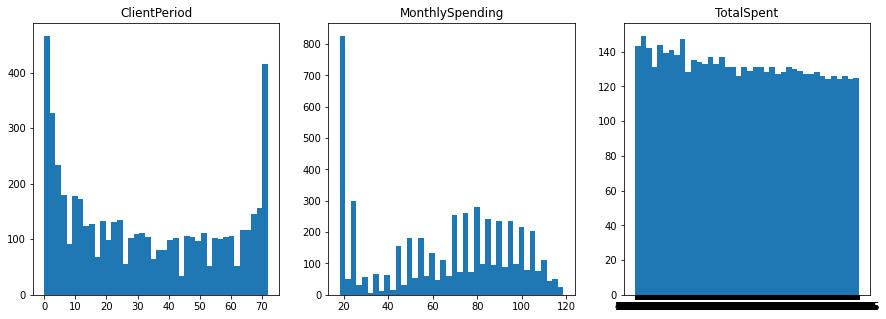

In [34]:
plt.figure(figsize=[15, 5])
i = 0
for col in num_cols:
    i+=1
    plt.subplot(1, 3, i)
    plt.hist(data[col], bins=40)
    plt.title(col)

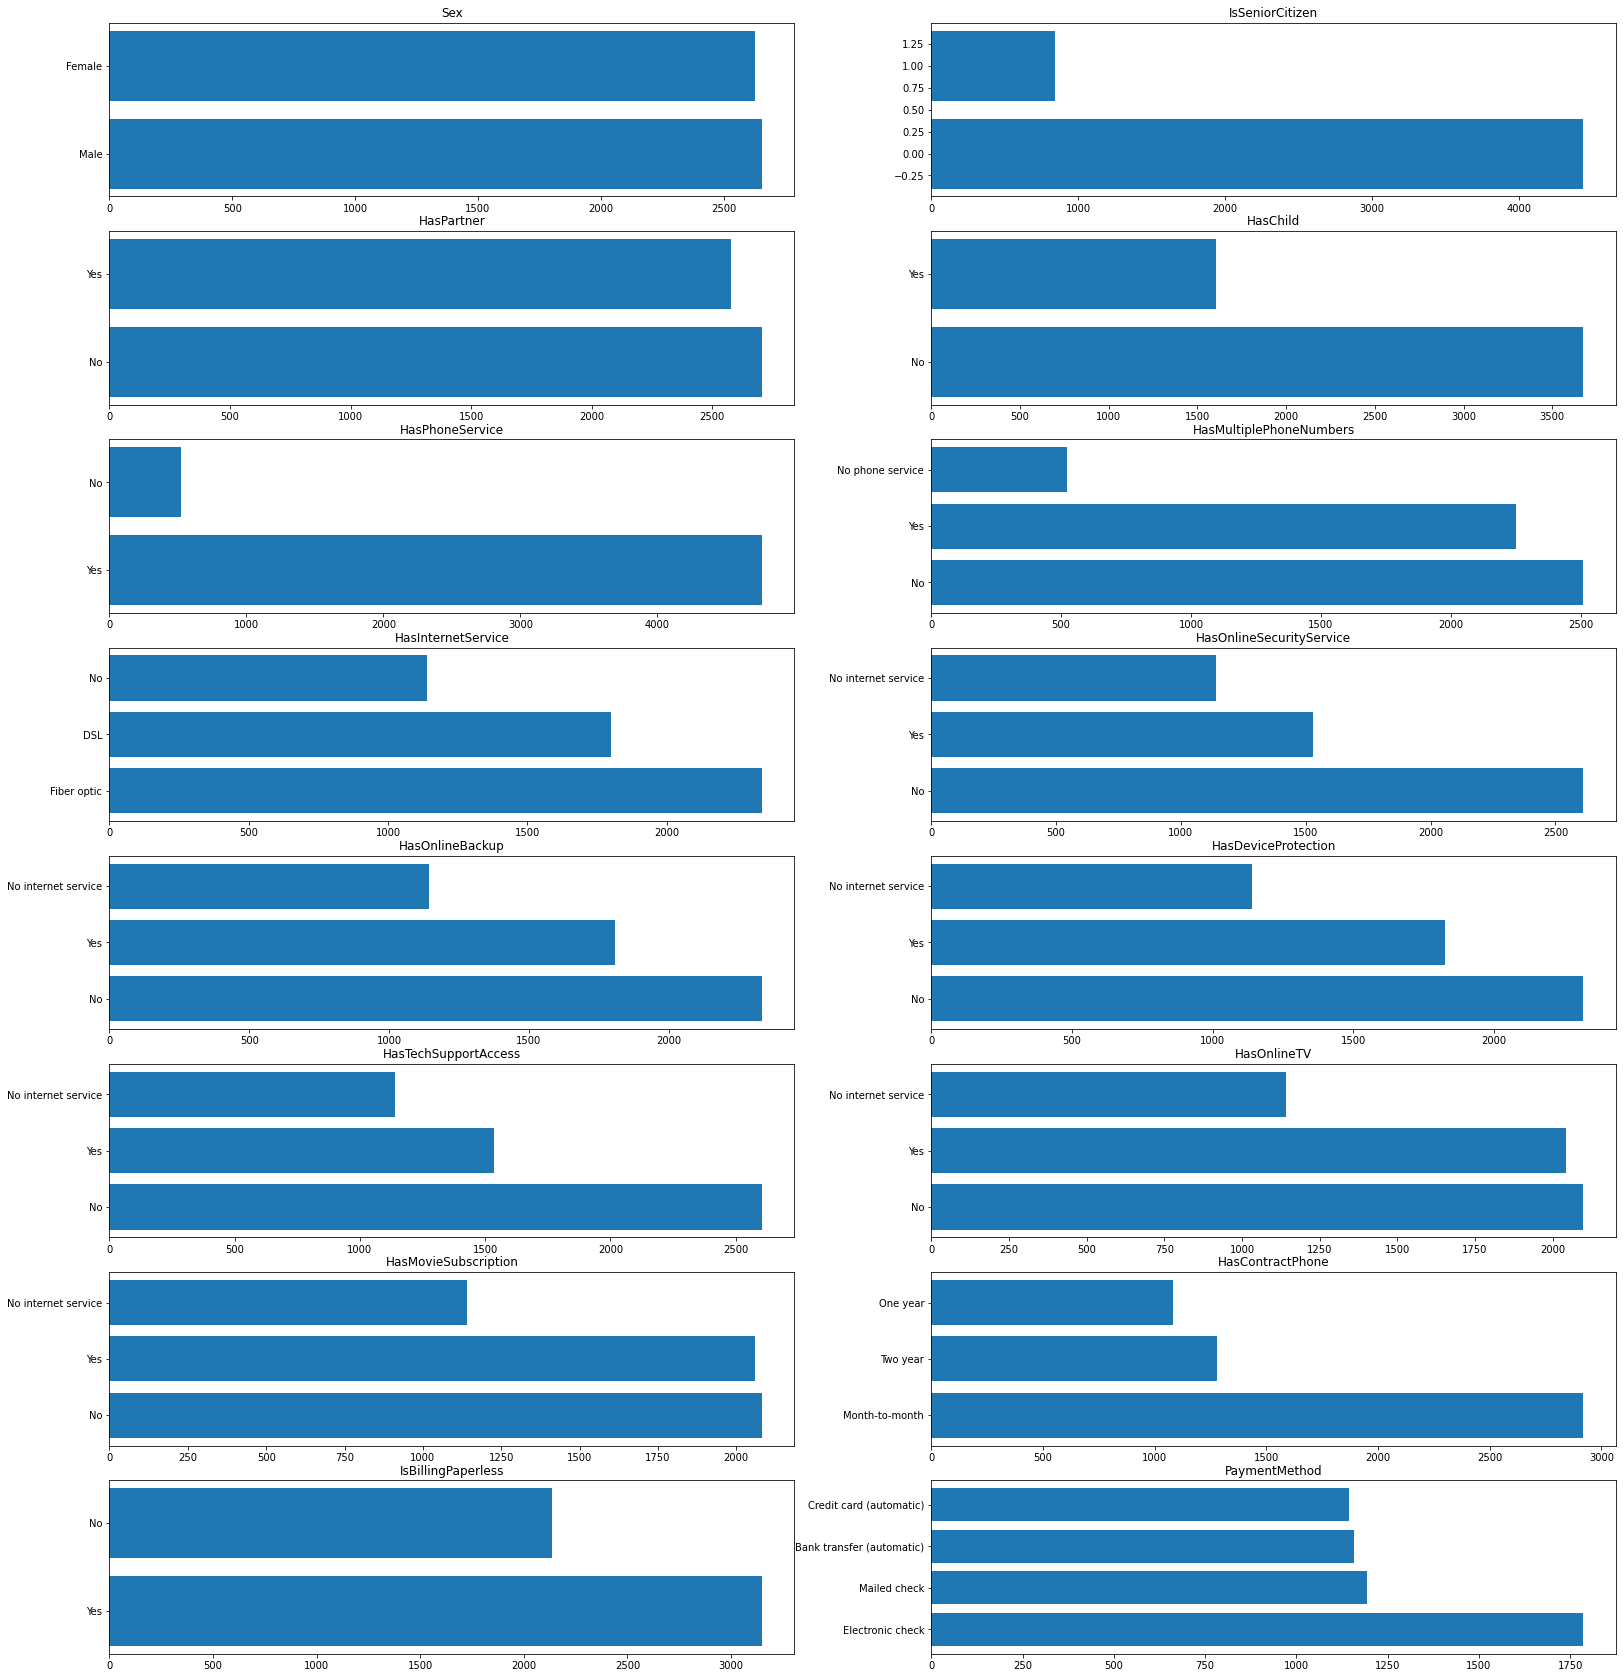

In [47]:
i=0
plt.figure(figsize=[27, 30])
for col in cat_cols:
    i+=1
    plt.subplot(8, 2, i)
    plt.barh(data[col].value_counts().index, data[col].value_counts().values)
    plt.title(col)

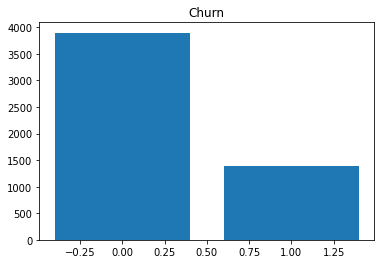

In [54]:
plt.bar(data['Churn'].value_counts().index, data['Churn'].value_counts().values)
plt.title('Churn');

Считаю, что классы несбаланированы совсем немного

(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

In [10]:
# YOUR CODE

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [11]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline

In [12]:
scaler = StandardScaler()
data['TotalSpent'] = pd.to_numeric(data['TotalSpent'])

from sklearn.compose import ColumnTransformer
transformer = ColumnTransformer(transformers=[
    ('tnf1', StandardScaler(), num_cols),
    ('tnf2', OneHotEncoder(), cat_cols)]
    )

In [13]:
pipeline = make_pipeline(transformer, LogisticRegression())
params = {'logisticregression__C':[ 100, 1, 0.1, 0.01, 0.001]}
LogisticRegression().get_params().keys()
grid = GridSearchCV(pipeline, params, cv=5, scoring='roc_auc')
grid.fit(data[feature_cols], data[target_col])

print(grid.best_score_)
print(grid.best_params_)

0.8448208909105489
{'logisticregression__C': 100}


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

0.8448208909105489 C=100

In [14]:
data.sample(5)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1418,10,85.25,855.30,Male,0,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,1
4172,65,58.90,3857.10,Female,0,Yes,No,Yes,No,DSL,Yes,No,Yes,Yes,No,No,Two year,No,Credit card (automatic),0
49,52,19.20,1054.75,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
3010,31,20.45,638.55,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
160,12,29.20,309.10,Female,0,Yes,Yes,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,No,Mailed check,1


## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [15]:
import catboost
X_train, X_valid, y_train, y_valid = train_test_split(data[feature_cols], data[target_col], 
                                                       train_size=0.8, 
                                                       random_state=42)

In [16]:
boosting_model = catboost.CatBoostClassifier(cat_features=cat_cols)

boosting_model.fit(X_train, y_train, cat_features=cat_cols)

Learning rate set to 0.019048
0:	learn: 0.6801499	total: 253ms	remaining: 4m 12s
1:	learn: 0.6683861	total: 332ms	remaining: 2m 45s
2:	learn: 0.6574055	total: 390ms	remaining: 2m 9s
3:	learn: 0.6459140	total: 482ms	remaining: 2m
4:	learn: 0.6353605	total: 568ms	remaining: 1m 52s
5:	learn: 0.6261610	total: 635ms	remaining: 1m 45s
6:	learn: 0.6167841	total: 728ms	remaining: 1m 43s
7:	learn: 0.6080311	total: 803ms	remaining: 1m 39s
8:	learn: 0.5997483	total: 877ms	remaining: 1m 36s
9:	learn: 0.5918432	total: 975ms	remaining: 1m 36s
10:	learn: 0.5839242	total: 1.05s	remaining: 1m 34s
11:	learn: 0.5766678	total: 1.13s	remaining: 1m 32s
12:	learn: 0.5701751	total: 1.18s	remaining: 1m 29s
13:	learn: 0.5631203	total: 1.28s	remaining: 1m 30s
14:	learn: 0.5566815	total: 1.35s	remaining: 1m 29s
15:	learn: 0.5507060	total: 1.44s	remaining: 1m 28s
16:	learn: 0.5449043	total: 1.52s	remaining: 1m 27s
17:	learn: 0.5390888	total: 1.6s	remaining: 1m 27s
18:	learn: 0.5338561	total: 1.68s	remaining: 1m 26

158:	learn: 0.3958247	total: 12.8s	remaining: 1m 7s
159:	learn: 0.3956630	total: 12.9s	remaining: 1m 7s
160:	learn: 0.3954968	total: 12.9s	remaining: 1m 7s
161:	learn: 0.3954302	total: 13s	remaining: 1m 7s
162:	learn: 0.3952112	total: 13.1s	remaining: 1m 7s
163:	learn: 0.3951401	total: 13.2s	remaining: 1m 7s
164:	learn: 0.3949517	total: 13.3s	remaining: 1m 7s
165:	learn: 0.3948067	total: 13.3s	remaining: 1m 7s
166:	learn: 0.3946294	total: 13.4s	remaining: 1m 7s
167:	learn: 0.3946068	total: 13.5s	remaining: 1m 6s
168:	learn: 0.3944551	total: 13.5s	remaining: 1m 6s
169:	learn: 0.3943255	total: 13.6s	remaining: 1m 6s
170:	learn: 0.3942594	total: 13.7s	remaining: 1m 6s
171:	learn: 0.3939716	total: 13.8s	remaining: 1m 6s
172:	learn: 0.3936969	total: 13.9s	remaining: 1m 6s
173:	learn: 0.3934543	total: 14s	remaining: 1m 6s
174:	learn: 0.3932836	total: 14.1s	remaining: 1m 6s
175:	learn: 0.3932141	total: 14.1s	remaining: 1m 6s
176:	learn: 0.3930316	total: 14.2s	remaining: 1m 6s
177:	learn: 0.39

318:	learn: 0.3791568	total: 25s	remaining: 53.3s
319:	learn: 0.3790870	total: 25s	remaining: 53.2s
320:	learn: 0.3790483	total: 25.1s	remaining: 53.1s
321:	learn: 0.3790385	total: 25.2s	remaining: 53s
322:	learn: 0.3790128	total: 25.2s	remaining: 52.9s
323:	learn: 0.3788952	total: 25.3s	remaining: 52.8s
324:	learn: 0.3788386	total: 25.4s	remaining: 52.7s
325:	learn: 0.3786201	total: 25.5s	remaining: 52.7s
326:	learn: 0.3786201	total: 25.5s	remaining: 52.5s
327:	learn: 0.3785585	total: 25.6s	remaining: 52.4s
328:	learn: 0.3784868	total: 25.7s	remaining: 52.3s
329:	learn: 0.3784859	total: 25.7s	remaining: 52.2s
330:	learn: 0.3784122	total: 25.8s	remaining: 52.1s
331:	learn: 0.3784045	total: 25.8s	remaining: 51.9s
332:	learn: 0.3782014	total: 25.9s	remaining: 51.8s
333:	learn: 0.3781965	total: 25.9s	remaining: 51.7s
334:	learn: 0.3780933	total: 26s	remaining: 51.7s
335:	learn: 0.3780705	total: 26.1s	remaining: 51.5s
336:	learn: 0.3780554	total: 26.1s	remaining: 51.4s
337:	learn: 0.377932

478:	learn: 0.3662016	total: 37.8s	remaining: 41.1s
479:	learn: 0.3660649	total: 37.8s	remaining: 41s
480:	learn: 0.3659552	total: 37.9s	remaining: 40.9s
481:	learn: 0.3658421	total: 38s	remaining: 40.9s
482:	learn: 0.3656858	total: 38.1s	remaining: 40.8s
483:	learn: 0.3656346	total: 38.2s	remaining: 40.7s
484:	learn: 0.3654980	total: 38.3s	remaining: 40.6s
485:	learn: 0.3653860	total: 38.4s	remaining: 40.6s
486:	learn: 0.3653087	total: 38.4s	remaining: 40.5s
487:	learn: 0.3651112	total: 38.6s	remaining: 40.5s
488:	learn: 0.3650358	total: 38.6s	remaining: 40.4s
489:	learn: 0.3649433	total: 38.7s	remaining: 40.3s
490:	learn: 0.3648812	total: 38.8s	remaining: 40.2s
491:	learn: 0.3648165	total: 38.9s	remaining: 40.2s
492:	learn: 0.3647715	total: 39s	remaining: 40.1s
493:	learn: 0.3646657	total: 39.1s	remaining: 40s
494:	learn: 0.3645388	total: 39.1s	remaining: 39.9s
495:	learn: 0.3644617	total: 39.2s	remaining: 39.9s
496:	learn: 0.3644029	total: 39.3s	remaining: 39.8s
497:	learn: 0.364346

637:	learn: 0.3499306	total: 51.7s	remaining: 29.3s
638:	learn: 0.3497372	total: 51.8s	remaining: 29.3s
639:	learn: 0.3496204	total: 51.9s	remaining: 29.2s
640:	learn: 0.3494877	total: 52s	remaining: 29.1s
641:	learn: 0.3494030	total: 52.1s	remaining: 29s
642:	learn: 0.3492897	total: 52.2s	remaining: 29s
643:	learn: 0.3491581	total: 52.2s	remaining: 28.9s
644:	learn: 0.3490782	total: 52.3s	remaining: 28.8s
645:	learn: 0.3490427	total: 52.4s	remaining: 28.7s
646:	learn: 0.3489004	total: 52.5s	remaining: 28.7s
647:	learn: 0.3488321	total: 52.6s	remaining: 28.6s
648:	learn: 0.3487439	total: 52.7s	remaining: 28.5s
649:	learn: 0.3486217	total: 52.8s	remaining: 28.4s
650:	learn: 0.3485563	total: 52.9s	remaining: 28.3s
651:	learn: 0.3483566	total: 53s	remaining: 28.3s
652:	learn: 0.3481104	total: 53s	remaining: 28.2s
653:	learn: 0.3480579	total: 53.1s	remaining: 28.1s
654:	learn: 0.3479928	total: 53.2s	remaining: 28s
655:	learn: 0.3478658	total: 53.3s	remaining: 28s
656:	learn: 0.3477812	tota

798:	learn: 0.3352952	total: 1m 5s	remaining: 16.5s
799:	learn: 0.3352246	total: 1m 5s	remaining: 16.5s
800:	learn: 0.3350968	total: 1m 5s	remaining: 16.4s
801:	learn: 0.3350534	total: 1m 5s	remaining: 16.3s
802:	learn: 0.3349849	total: 1m 6s	remaining: 16.2s
803:	learn: 0.3349792	total: 1m 6s	remaining: 16.1s
804:	learn: 0.3349638	total: 1m 6s	remaining: 16s
805:	learn: 0.3348651	total: 1m 6s	remaining: 16s
806:	learn: 0.3347896	total: 1m 6s	remaining: 15.9s
807:	learn: 0.3347491	total: 1m 6s	remaining: 15.8s
808:	learn: 0.3346838	total: 1m 6s	remaining: 15.7s
809:	learn: 0.3346298	total: 1m 6s	remaining: 15.6s
810:	learn: 0.3345146	total: 1m 6s	remaining: 15.5s
811:	learn: 0.3343589	total: 1m 6s	remaining: 15.5s
812:	learn: 0.3342499	total: 1m 6s	remaining: 15.4s
813:	learn: 0.3341817	total: 1m 6s	remaining: 15.3s
814:	learn: 0.3340475	total: 1m 7s	remaining: 15.2s
815:	learn: 0.3339547	total: 1m 7s	remaining: 15.1s
816:	learn: 0.3338621	total: 1m 7s	remaining: 15.1s
817:	learn: 0.33

956:	learn: 0.3234790	total: 1m 19s	remaining: 3.56s
957:	learn: 0.3234040	total: 1m 19s	remaining: 3.48s
958:	learn: 0.3233577	total: 1m 19s	remaining: 3.4s
959:	learn: 0.3233116	total: 1m 19s	remaining: 3.31s
960:	learn: 0.3232024	total: 1m 19s	remaining: 3.23s
961:	learn: 0.3231761	total: 1m 19s	remaining: 3.15s
962:	learn: 0.3230830	total: 1m 19s	remaining: 3.07s
963:	learn: 0.3229206	total: 1m 19s	remaining: 2.98s
964:	learn: 0.3228812	total: 1m 19s	remaining: 2.9s
965:	learn: 0.3227692	total: 1m 20s	remaining: 2.82s
966:	learn: 0.3227130	total: 1m 20s	remaining: 2.73s
967:	learn: 0.3226317	total: 1m 20s	remaining: 2.65s
968:	learn: 0.3224459	total: 1m 20s	remaining: 2.57s
969:	learn: 0.3223674	total: 1m 20s	remaining: 2.48s
970:	learn: 0.3223229	total: 1m 20s	remaining: 2.4s
971:	learn: 0.3222928	total: 1m 20s	remaining: 2.32s
972:	learn: 0.3222494	total: 1m 20s	remaining: 2.24s
973:	learn: 0.3221743	total: 1m 20s	remaining: 2.15s
974:	learn: 0.3221029	total: 1m 20s	remaining: 2.

In [17]:
y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_valid_predicted = boosting_model.predict_proba(X_valid)[:, 1]
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_valid, y_valid_predicted)
print(train_auc, test_auc)

0.8934524745969756 0.8404411417787214


In [18]:
# пробую GridSearchCV
parameters = {'learning_rate' : [0.01,0.02,0.03,0.04],
               'iterations' : [50, 100, 150, 200]
              }
grid = GridSearchCV(estimator=boosting_model, param_grid = parameters, n_jobs=-1, scoring='roc_auc')
grid.fit(data[feature_cols], data[target_col])
print(grid.best_score_)
print(grid.best_params_)

0:	learn: 0.6736020	total: 47ms	remaining: 9.36s
1:	learn: 0.6545445	total: 96ms	remaining: 9.51s
2:	learn: 0.6415304	total: 112ms	remaining: 7.35s
3:	learn: 0.6270078	total: 141ms	remaining: 6.93s
4:	learn: 0.6120779	total: 185ms	remaining: 7.2s
5:	learn: 0.5988539	total: 229ms	remaining: 7.4s
6:	learn: 0.5859113	total: 273ms	remaining: 7.53s
7:	learn: 0.5747058	total: 332ms	remaining: 7.97s
8:	learn: 0.5642878	total: 398ms	remaining: 8.46s
9:	learn: 0.5550924	total: 446ms	remaining: 8.47s
10:	learn: 0.5458040	total: 492ms	remaining: 8.45s
11:	learn: 0.5357855	total: 545ms	remaining: 8.53s
12:	learn: 0.5284379	total: 597ms	remaining: 8.59s
13:	learn: 0.5198794	total: 643ms	remaining: 8.54s
14:	learn: 0.5125555	total: 685ms	remaining: 8.45s
15:	learn: 0.5066925	total: 725ms	remaining: 8.34s
16:	learn: 0.5005044	total: 792ms	remaining: 8.53s
17:	learn: 0.4944873	total: 860ms	remaining: 8.7s
18:	learn: 0.4892912	total: 911ms	remaining: 8.68s
19:	learn: 0.4848378	total: 948ms	remaining: 8

161:	learn: 0.3888891	total: 7.96s	remaining: 1.87s
162:	learn: 0.3887430	total: 8.02s	remaining: 1.82s
163:	learn: 0.3883300	total: 8.06s	remaining: 1.77s
164:	learn: 0.3882397	total: 8.11s	remaining: 1.72s
165:	learn: 0.3882213	total: 8.14s	remaining: 1.67s
166:	learn: 0.3880615	total: 8.19s	remaining: 1.62s
167:	learn: 0.3880169	total: 8.25s	remaining: 1.57s
168:	learn: 0.3878775	total: 8.31s	remaining: 1.52s
169:	learn: 0.3878762	total: 8.33s	remaining: 1.47s
170:	learn: 0.3876747	total: 8.37s	remaining: 1.42s
171:	learn: 0.3876392	total: 8.42s	remaining: 1.37s
172:	learn: 0.3876305	total: 8.44s	remaining: 1.32s
173:	learn: 0.3875449	total: 8.48s	remaining: 1.27s
174:	learn: 0.3873106	total: 8.52s	remaining: 1.22s
175:	learn: 0.3871669	total: 8.62s	remaining: 1.17s
176:	learn: 0.3871664	total: 8.63s	remaining: 1.12s
177:	learn: 0.3869608	total: 8.69s	remaining: 1.07s
178:	learn: 0.3866802	total: 8.75s	remaining: 1.03s
179:	learn: 0.3863954	total: 8.8s	remaining: 977ms
180:	learn: 0

In [20]:
# в чём же разница между GridSearchCV и катбустовским grid_search...
# пробую катбустовский grid_search с кроссвалидацией
boosting_model_cat2 = catboost.CatBoostClassifier(cat_features=cat_cols, eval_metric='AUC')
grid_cat2 = boosting_model_cat2.grid_search({'learning_rate' : [0.01,0.02,0.03,0.04],
                 'iterations' : [150, 200, 300]}, data[feature_cols], data[target_col], search_by_train_test_split=False, cv=5, refit=True)

Training on fold [0/5]
0:	test: 0.7653476	best: 0.7653476 (0)	total: 43.1ms	remaining: 6.42s
1:	test: 0.7930313	best: 0.7930313 (1)	total: 111ms	remaining: 8.21s
2:	test: 0.7934767	best: 0.7934767 (2)	total: 196ms	remaining: 9.59s
3:	test: 0.7983444	best: 0.7983444 (3)	total: 273ms	remaining: 9.95s
4:	test: 0.7958131	best: 0.7983444 (3)	total: 309ms	remaining: 8.95s
5:	test: 0.7931218	best: 0.7983444 (3)	total: 373ms	remaining: 8.96s
6:	test: 0.7955579	best: 0.7983444 (3)	total: 464ms	remaining: 9.48s
7:	test: 0.7981634	best: 0.7983444 (3)	total: 506ms	remaining: 8.98s
8:	test: 0.7991494	best: 0.7991494 (8)	total: 551ms	remaining: 8.63s
9:	test: 0.8007225	best: 0.8007225 (9)	total: 641ms	remaining: 8.97s
10:	test: 0.8009313	best: 0.8009313 (10)	total: 717ms	remaining: 9.06s
11:	test: 0.8039034	best: 0.8039034 (11)	total: 751ms	remaining: 8.64s
12:	test: 0.8056458	best: 0.8056458 (12)	total: 810ms	remaining: 8.54s
13:	test: 0.8053511	best: 0.8056458 (12)	total: 852ms	remaining: 8.28s
14

119:	test: 0.8281510	best: 0.8281510 (119)	total: 6.52s	remaining: 1.63s
120:	test: 0.8281510	best: 0.8281510 (119)	total: 6.57s	remaining: 1.57s
121:	test: 0.8282020	best: 0.8282020 (121)	total: 6.62s	remaining: 1.52s
122:	test: 0.8282159	best: 0.8282159 (122)	total: 6.66s	remaining: 1.46s
123:	test: 0.8282345	best: 0.8282345 (123)	total: 6.68s	remaining: 1.4s
124:	test: 0.8283273	best: 0.8283273 (124)	total: 6.72s	remaining: 1.34s
125:	test: 0.8283180	best: 0.8283273 (124)	total: 6.76s	remaining: 1.29s
126:	test: 0.8283969	best: 0.8283969 (126)	total: 6.8s	remaining: 1.23s
127:	test: 0.8285500	best: 0.8285500 (127)	total: 6.83s	remaining: 1.17s
128:	test: 0.8287913	best: 0.8287913 (128)	total: 6.88s	remaining: 1.12s
129:	test: 0.8289491	best: 0.8289491 (129)	total: 6.95s	remaining: 1.07s
130:	test: 0.8290419	best: 0.8290419 (130)	total: 7s	remaining: 1.01s
131:	test: 0.8291300	best: 0.8291300 (131)	total: 7.04s	remaining: 960ms
132:	test: 0.8293249	best: 0.8293249 (132)	total: 7.08s	

84:	test: 0.8116967	best: 0.8116967 (84)	total: 4.42s	remaining: 3.38s
85:	test: 0.8119380	best: 0.8119380 (85)	total: 4.46s	remaining: 3.32s
86:	test: 0.8122860	best: 0.8122860 (86)	total: 4.49s	remaining: 3.25s
87:	test: 0.8123092	best: 0.8123092 (87)	total: 4.56s	remaining: 3.21s
88:	test: 0.8125041	best: 0.8125041 (88)	total: 4.6s	remaining: 3.15s
89:	test: 0.8127593	best: 0.8127593 (89)	total: 4.65s	remaining: 3.1s
90:	test: 0.8128938	best: 0.8128938 (90)	total: 4.68s	remaining: 3.04s
91:	test: 0.8132511	best: 0.8132511 (91)	total: 4.74s	remaining: 2.99s
92:	test: 0.8135156	best: 0.8135156 (92)	total: 4.79s	remaining: 2.94s
93:	test: 0.8138404	best: 0.8138404 (93)	total: 4.84s	remaining: 2.88s
94:	test: 0.8139704	best: 0.8139704 (94)	total: 4.88s	remaining: 2.83s
95:	test: 0.8140632	best: 0.8140632 (95)	total: 4.92s	remaining: 2.77s
96:	test: 0.8140817	best: 0.8140817 (96)	total: 4.96s	remaining: 2.71s
97:	test: 0.8144251	best: 0.8144251 (97)	total: 5s	remaining: 2.65s
98:	test: 0

49:	test: 0.8469138	best: 0.8469138 (49)	total: 2.8s	remaining: 5.6s
50:	test: 0.8479277	best: 0.8479277 (50)	total: 2.85s	remaining: 5.53s
51:	test: 0.8485170	best: 0.8485170 (51)	total: 2.88s	remaining: 5.43s
52:	test: 0.8493569	best: 0.8493569 (52)	total: 2.92s	remaining: 5.35s
53:	test: 0.8503406	best: 0.8503406 (53)	total: 2.95s	remaining: 5.25s
54:	test: 0.8509531	best: 0.8509531 (54)	total: 3.02s	remaining: 5.22s
55:	test: 0.8514473	best: 0.8514473 (55)	total: 3.07s	remaining: 5.16s
56:	test: 0.8519925	best: 0.8519925 (56)	total: 3.15s	remaining: 5.13s
57:	test: 0.8522849	best: 0.8522849 (57)	total: 3.2s	remaining: 5.08s
58:	test: 0.8525493	best: 0.8525493 (58)	total: 3.26s	remaining: 5.02s
59:	test: 0.8530227	best: 0.8530227 (59)	total: 3.31s	remaining: 4.96s
60:	test: 0.8536398	best: 0.8536398 (60)	total: 3.37s	remaining: 4.92s
61:	test: 0.8541827	best: 0.8541827 (61)	total: 3.42s	remaining: 4.86s
62:	test: 0.8544936	best: 0.8544936 (62)	total: 3.5s	remaining: 4.83s
63:	test: 

15:	test: 0.8057734	best: 0.8062977 (12)	total: 840ms	remaining: 7.03s
16:	test: 0.8064114	best: 0.8064114 (16)	total: 906ms	remaining: 7.09s
17:	test: 0.8064949	best: 0.8064949 (17)	total: 953ms	remaining: 6.99s
18:	test: 0.8068314	best: 0.8068314 (18)	total: 1s	remaining: 6.93s
19:	test: 0.8072907	best: 0.8072907 (19)	total: 1.07s	remaining: 6.95s
20:	test: 0.8080077	best: 0.8080077 (20)	total: 1.12s	remaining: 6.88s
21:	test: 0.8077107	best: 0.8080077 (20)	total: 1.19s	remaining: 6.92s
22:	test: 0.8084531	best: 0.8084531 (22)	total: 1.26s	remaining: 6.95s
23:	test: 0.8088267	best: 0.8088267 (23)	total: 1.31s	remaining: 6.9s
24:	test: 0.8091028	best: 0.8091028 (24)	total: 1.36s	remaining: 6.8s
25:	test: 0.8089009	best: 0.8091028 (24)	total: 1.42s	remaining: 6.79s
26:	test: 0.8082374	best: 0.8091028 (24)	total: 1.47s	remaining: 6.68s
27:	test: 0.8086735	best: 0.8091028 (24)	total: 1.53s	remaining: 6.69s
28:	test: 0.8098127	best: 0.8098127 (28)	total: 1.59s	remaining: 6.63s
29:	test: 0

133:	test: 0.8371321	best: 0.8371321 (133)	total: 7.47s	remaining: 892ms
134:	test: 0.8372574	best: 0.8372574 (134)	total: 7.5s	remaining: 833ms
135:	test: 0.8373224	best: 0.8373224 (135)	total: 7.55s	remaining: 777ms
136:	test: 0.8373642	best: 0.8373642 (136)	total: 7.63s	remaining: 724ms
137:	test: 0.8374291	best: 0.8374291 (137)	total: 7.65s	remaining: 666ms
138:	test: 0.8375590	best: 0.8375590 (138)	total: 7.73s	remaining: 612ms
139:	test: 0.8377075	best: 0.8377075 (139)	total: 7.77s	remaining: 555ms
140:	test: 0.8378421	best: 0.8378421 (140)	total: 7.8s	remaining: 498ms
141:	test: 0.8379442	best: 0.8379442 (141)	total: 7.85s	remaining: 442ms
142:	test: 0.8380927	best: 0.8380927 (142)	total: 7.88s	remaining: 386ms
143:	test: 0.8381762	best: 0.8381762 (143)	total: 7.93s	remaining: 330ms
144:	test: 0.8382644	best: 0.8382644 (144)	total: 7.97s	remaining: 275ms
145:	test: 0.8383386	best: 0.8383386 (145)	total: 8.03s	remaining: 220ms
146:	test: 0.8383572	best: 0.8383572 (146)	total: 8.0

98:	test: 0.8324007	best: 0.8324007 (98)	total: 5.5s	remaining: 2.83s
99:	test: 0.8326992	best: 0.8326992 (99)	total: 5.57s	remaining: 2.79s
100:	test: 0.8330256	best: 0.8330256 (100)	total: 5.62s	remaining: 2.72s
101:	test: 0.8333193	best: 0.8333193 (101)	total: 5.68s	remaining: 2.67s
102:	test: 0.8336504	best: 0.8336504 (102)	total: 5.74s	remaining: 2.62s
103:	test: 0.8340794	best: 0.8340794 (103)	total: 5.79s	remaining: 2.56s
104:	test: 0.8345177	best: 0.8345177 (104)	total: 5.88s	remaining: 2.52s
105:	test: 0.8346996	best: 0.8346996 (105)	total: 5.91s	remaining: 2.45s
106:	test: 0.8350074	best: 0.8350074 (106)	total: 5.96s	remaining: 2.4s
107:	test: 0.8350587	best: 0.8350587 (107)	total: 6.04s	remaining: 2.35s
108:	test: 0.8352172	best: 0.8352172 (108)	total: 6.08s	remaining: 2.29s
109:	test: 0.8354084	best: 0.8354084 (109)	total: 6.13s	remaining: 2.23s
110:	test: 0.8357162	best: 0.8357162 (110)	total: 6.16s	remaining: 2.17s
111:	test: 0.8359167	best: 0.8359167 (111)	total: 6.22s	r

63:	test: 0.8286892	best: 0.8286892 (63)	total: 3.59s	remaining: 4.83s
64:	test: 0.8287171	best: 0.8287171 (64)	total: 3.64s	remaining: 4.76s
65:	test: 0.8288331	best: 0.8288331 (65)	total: 3.68s	remaining: 4.69s
66:	test: 0.8288841	best: 0.8288841 (66)	total: 3.71s	remaining: 4.59s
67:	test: 0.8290233	best: 0.8290233 (67)	total: 3.75s	remaining: 4.53s
68:	test: 0.8291393	best: 0.8291393 (68)	total: 3.83s	remaining: 4.5s
69:	test: 0.8290720	best: 0.8291393 (68)	total: 3.88s	remaining: 4.43s
70:	test: 0.8288957	best: 0.8291393 (68)	total: 3.94s	remaining: 4.38s
71:	test: 0.8289468	best: 0.8291393 (68)	total: 3.99s	remaining: 4.33s
72:	test: 0.8289746	best: 0.8291393 (68)	total: 4.04s	remaining: 4.26s
73:	test: 0.8290396	best: 0.8291393 (68)	total: 4.08s	remaining: 4.19s
74:	test: 0.8291509	best: 0.8291509 (74)	total: 4.13s	remaining: 4.13s
75:	test: 0.8292948	best: 0.8292948 (75)	total: 4.24s	remaining: 4.13s
76:	test: 0.8293690	best: 0.8293690 (76)	total: 4.29s	remaining: 4.06s
77:	tes

27:	test: 0.7976135	best: 0.7977226 (22)	total: 1.66s	remaining: 7.21s
28:	test: 0.7998919	best: 0.7998919 (28)	total: 1.71s	remaining: 7.14s
29:	test: 0.8008524	best: 0.8008524 (29)	total: 1.75s	remaining: 7.01s
30:	test: 0.8017155	best: 0.8017155 (30)	total: 1.77s	remaining: 6.78s
31:	test: 0.8022978	best: 0.8022978 (31)	total: 1.81s	remaining: 6.68s
32:	test: 0.8030217	best: 0.8030217 (32)	total: 1.87s	remaining: 6.62s
33:	test: 0.8033605	best: 0.8033605 (33)	total: 1.9s	remaining: 6.49s
34:	test: 0.8043604	best: 0.8043604 (34)	total: 1.99s	remaining: 6.54s
35:	test: 0.8049497	best: 0.8049497 (35)	total: 2.06s	remaining: 6.54s
36:	test: 0.8057107	best: 0.8057107 (36)	total: 2.13s	remaining: 6.51s
37:	test: 0.8064648	best: 0.8064648 (37)	total: 2.19s	remaining: 6.46s
38:	test: 0.8072026	best: 0.8072026 (38)	total: 2.24s	remaining: 6.37s
39:	test: 0.8075877	best: 0.8075877 (39)	total: 2.28s	remaining: 6.27s
40:	test: 0.8081678	best: 0.8081678 (40)	total: 2.33s	remaining: 6.21s
41:	tes

145:	test: 0.8259584	best: 0.8259584 (145)	total: 7.96s	remaining: 218ms
146:	test: 0.8260048	best: 0.8260048 (146)	total: 8.03s	remaining: 164ms
147:	test: 0.8259770	best: 0.8260048 (146)	total: 8.08s	remaining: 109ms
148:	test: 0.8261905	best: 0.8261905 (148)	total: 8.16s	remaining: 54.8ms
149:	test: 0.8261858	best: 0.8261905 (148)	total: 8.21s	remaining: 0us

bestTest = 0.8261904541
bestIteration = 148

Training on fold [2/5]
0:	test: 0.8074137	best: 0.8074137 (0)	total: 64.9ms	remaining: 9.68s
1:	test: 0.8318771	best: 0.8318771 (1)	total: 161ms	remaining: 11.9s
2:	test: 0.8336357	best: 0.8336357 (2)	total: 231ms	remaining: 11.3s
3:	test: 0.8389117	best: 0.8389117 (3)	total: 315ms	remaining: 11.5s
4:	test: 0.8392040	best: 0.8392040 (4)	total: 379ms	remaining: 11s
5:	test: 0.8396309	best: 0.8396309 (5)	total: 465ms	remaining: 11.2s
6:	test: 0.8386518	best: 0.8396309 (5)	total: 530ms	remaining: 10.8s
7:	test: 0.8445681	best: 0.8445681 (7)	total: 580ms	remaining: 10.3s
8:	test: 0.84273

110:	test: 0.8621546	best: 0.8632265 (82)	total: 6.11s	remaining: 2.15s
111:	test: 0.8621964	best: 0.8632265 (82)	total: 6.17s	remaining: 2.09s
112:	test: 0.8620618	best: 0.8632265 (82)	total: 6.24s	remaining: 2.04s
113:	test: 0.8621361	best: 0.8632265 (82)	total: 6.28s	remaining: 1.98s
114:	test: 0.8621082	best: 0.8632265 (82)	total: 6.34s	remaining: 1.93s
115:	test: 0.8621918	best: 0.8632265 (82)	total: 6.42s	remaining: 1.88s
116:	test: 0.8621593	best: 0.8632265 (82)	total: 6.49s	remaining: 1.83s
117:	test: 0.8620943	best: 0.8632265 (82)	total: 6.54s	remaining: 1.77s
118:	test: 0.8622011	best: 0.8632265 (82)	total: 6.61s	remaining: 1.72s
119:	test: 0.8621825	best: 0.8632265 (82)	total: 6.67s	remaining: 1.67s
120:	test: 0.8621779	best: 0.8632265 (82)	total: 6.74s	remaining: 1.61s
121:	test: 0.8621407	best: 0.8632265 (82)	total: 6.78s	remaining: 1.55s
122:	test: 0.8620897	best: 0.8632265 (82)	total: 6.81s	remaining: 1.5s
123:	test: 0.8618902	best: 0.8632265 (82)	total: 6.86s	remaining:

78:	test: 0.8361809	best: 0.8361809 (78)	total: 4.05s	remaining: 3.64s
79:	test: 0.8364083	best: 0.8364083 (79)	total: 4.12s	remaining: 3.6s
80:	test: 0.8364872	best: 0.8364872 (80)	total: 4.19s	remaining: 3.57s
81:	test: 0.8366913	best: 0.8366913 (81)	total: 4.22s	remaining: 3.5s
82:	test: 0.8367934	best: 0.8367934 (82)	total: 4.26s	remaining: 3.44s
83:	test: 0.8368352	best: 0.8368352 (83)	total: 4.31s	remaining: 3.39s
84:	test: 0.8369187	best: 0.8369187 (84)	total: 4.38s	remaining: 3.35s
85:	test: 0.8371600	best: 0.8371600 (85)	total: 4.44s	remaining: 3.31s
86:	test: 0.8372157	best: 0.8372157 (86)	total: 4.49s	remaining: 3.25s
87:	test: 0.8372714	best: 0.8372714 (87)	total: 4.55s	remaining: 3.21s
88:	test: 0.8372806	best: 0.8372806 (88)	total: 4.6s	remaining: 3.15s
89:	test: 0.8373410	best: 0.8373410 (89)	total: 4.64s	remaining: 3.1s
90:	test: 0.8373224	best: 0.8373410 (89)	total: 4.69s	remaining: 3.04s
91:	test: 0.8372621	best: 0.8373410 (89)	total: 4.74s	remaining: 2.98s
92:	test: 

44:	test: 0.8369682	best: 0.8369682 (44)	total: 2.73s	remaining: 6.37s
45:	test: 0.8374578	best: 0.8374578 (45)	total: 2.81s	remaining: 6.36s
46:	test: 0.8377562	best: 0.8377562 (46)	total: 2.87s	remaining: 6.28s
47:	test: 0.8379451	best: 0.8379451 (47)	total: 2.94s	remaining: 6.26s
48:	test: 0.8385490	best: 0.8385490 (48)	total: 3.03s	remaining: 6.25s
49:	test: 0.8387728	best: 0.8387728 (49)	total: 3.1s	remaining: 6.21s
50:	test: 0.8389103	best: 0.8389103 (50)	total: 3.16s	remaining: 6.14s
51:	test: 0.8393160	best: 0.8393160 (51)	total: 3.25s	remaining: 6.13s
52:	test: 0.8396005	best: 0.8396005 (52)	total: 3.32s	remaining: 6.07s
53:	test: 0.8397474	best: 0.8397474 (53)	total: 3.38s	remaining: 6.01s
54:	test: 0.8398779	best: 0.8398779 (54)	total: 3.44s	remaining: 5.93s
55:	test: 0.8402650	best: 0.8402650 (55)	total: 3.5s	remaining: 5.88s
56:	test: 0.8411463	best: 0.8411463 (56)	total: 3.59s	remaining: 5.86s
57:	test: 0.8421115	best: 0.8421115 (57)	total: 3.66s	remaining: 5.81s
58:	test

7:	test: 0.8007874	best: 0.8007874 (7)	total: 444ms	remaining: 7.88s
8:	test: 0.8013860	best: 0.8013860 (8)	total: 497ms	remaining: 7.79s
9:	test: 0.8022514	best: 0.8022514 (9)	total: 548ms	remaining: 7.67s
10:	test: 0.8030055	best: 0.8030055 (10)	total: 588ms	remaining: 7.43s
11:	test: 0.8064416	best: 0.8064416 (11)	total: 626ms	remaining: 7.2s
12:	test: 0.8055623	best: 0.8064416 (11)	total: 665ms	remaining: 7.01s
13:	test: 0.8058592	best: 0.8064416 (11)	total: 706ms	remaining: 6.86s
14:	test: 0.8061400	best: 0.8064416 (11)	total: 759ms	remaining: 6.83s
15:	test: 0.8074949	best: 0.8074949 (15)	total: 796ms	remaining: 6.67s
16:	test: 0.8071214	best: 0.8074949 (15)	total: 844ms	remaining: 6.61s
17:	test: 0.8070123	best: 0.8074949 (15)	total: 889ms	remaining: 6.52s
18:	test: 0.8075877	best: 0.8075877 (18)	total: 947ms	remaining: 6.53s
19:	test: 0.8083974	best: 0.8083974 (19)	total: 994ms	remaining: 6.46s
20:	test: 0.8083487	best: 0.8083974 (19)	total: 1.06s	remaining: 6.5s
21:	test: 0.80

124:	test: 0.8364199	best: 0.8364199 (124)	total: 6.05s	remaining: 1.21s
125:	test: 0.8365452	best: 0.8365452 (125)	total: 6.08s	remaining: 1.16s
126:	test: 0.8366890	best: 0.8366890 (126)	total: 6.14s	remaining: 1.11s
127:	test: 0.8367122	best: 0.8367122 (127)	total: 6.18s	remaining: 1.06s
128:	test: 0.8368978	best: 0.8368978 (128)	total: 6.22s	remaining: 1.01s
129:	test: 0.8368885	best: 0.8368978 (128)	total: 6.27s	remaining: 964ms
130:	test: 0.8369025	best: 0.8369025 (130)	total: 6.28s	remaining: 911ms
131:	test: 0.8369674	best: 0.8369674 (131)	total: 6.3s	remaining: 859ms
132:	test: 0.8368885	best: 0.8369674 (131)	total: 6.35s	remaining: 811ms
133:	test: 0.8369674	best: 0.8369674 (131)	total: 6.39s	remaining: 763ms
134:	test: 0.8370138	best: 0.8370138 (134)	total: 6.43s	remaining: 714ms
135:	test: 0.8370231	best: 0.8370231 (135)	total: 6.47s	remaining: 666ms
136:	test: 0.8369581	best: 0.8370231 (135)	total: 6.54s	remaining: 620ms
137:	test: 0.8370649	best: 0.8370649 (137)	total: 6.

89:	test: 0.8242323	best: 0.8242926 (85)	total: 4.73s	remaining: 3.15s
90:	test: 0.8241627	best: 0.8242926 (85)	total: 4.78s	remaining: 3.1s
91:	test: 0.8244666	best: 0.8244666 (91)	total: 4.83s	remaining: 3.04s
92:	test: 0.8243413	best: 0.8244666 (91)	total: 4.89s	remaining: 3s
93:	test: 0.8245640	best: 0.8245640 (93)	total: 4.97s	remaining: 2.96s
94:	test: 0.8245826	best: 0.8245826 (94)	total: 5.01s	remaining: 2.9s
95:	test: 0.8244666	best: 0.8245826 (94)	total: 5.06s	remaining: 2.85s
96:	test: 0.8246986	best: 0.8246986 (96)	total: 5.13s	remaining: 2.8s
97:	test: 0.8246197	best: 0.8246986 (96)	total: 5.18s	remaining: 2.75s
98:	test: 0.8247218	best: 0.8247218 (98)	total: 5.24s	remaining: 2.7s
99:	test: 0.8247079	best: 0.8247218 (98)	total: 5.3s	remaining: 2.65s
100:	test: 0.8248007	best: 0.8248007 (100)	total: 5.32s	remaining: 2.58s
101:	test: 0.8250142	best: 0.8250142 (101)	total: 5.38s	remaining: 2.53s
102:	test: 0.8250698	best: 0.8250698 (102)	total: 5.47s	remaining: 2.5s
103:	test

53:	test: 0.8619157	best: 0.8621430 (45)	total: 2.63s	remaining: 4.67s
54:	test: 0.8620827	best: 0.8621430 (45)	total: 2.71s	remaining: 4.68s
55:	test: 0.8620618	best: 0.8621430 (45)	total: 2.75s	remaining: 4.62s
56:	test: 0.8619551	best: 0.8621430 (45)	total: 2.79s	remaining: 4.56s
57:	test: 0.8618206	best: 0.8621430 (45)	total: 2.82s	remaining: 4.48s
58:	test: 0.8618902	best: 0.8621430 (45)	total: 2.86s	remaining: 4.41s
59:	test: 0.8617231	best: 0.8621430 (45)	total: 2.94s	remaining: 4.41s
60:	test: 0.8614818	best: 0.8621430 (45)	total: 2.99s	remaining: 4.36s
61:	test: 0.8614957	best: 0.8621430 (45)	total: 3.02s	remaining: 4.29s
62:	test: 0.8615143	best: 0.8621430 (45)	total: 3.09s	remaining: 4.27s
63:	test: 0.8614679	best: 0.8621430 (45)	total: 3.12s	remaining: 4.19s
64:	test: 0.8613751	best: 0.8621430 (45)	total: 3.17s	remaining: 4.14s
65:	test: 0.8614679	best: 0.8621430 (45)	total: 3.21s	remaining: 4.08s
66:	test: 0.8613287	best: 0.8621430 (45)	total: 3.24s	remaining: 4.02s
67:	te

20:	test: 0.8105157	best: 0.8105157 (20)	total: 1.11s	remaining: 6.8s
21:	test: 0.8112999	best: 0.8112999 (21)	total: 1.16s	remaining: 6.76s
22:	test: 0.8133277	best: 0.8133277 (22)	total: 1.23s	remaining: 6.77s
23:	test: 0.8150353	best: 0.8150353 (23)	total: 1.28s	remaining: 6.71s
24:	test: 0.8159030	best: 0.8159030 (24)	total: 1.35s	remaining: 6.73s
25:	test: 0.8166617	best: 0.8166617 (25)	total: 1.41s	remaining: 6.73s
26:	test: 0.8173902	best: 0.8173902 (26)	total: 1.45s	remaining: 6.62s
27:	test: 0.8178079	best: 0.8178079 (27)	total: 1.53s	remaining: 6.66s
28:	test: 0.8185085	best: 0.8185085 (28)	total: 1.57s	remaining: 6.54s
29:	test: 0.8189076	best: 0.8189076 (29)	total: 1.62s	remaining: 6.48s
30:	test: 0.8191489	best: 0.8191489 (30)	total: 1.67s	remaining: 6.43s
31:	test: 0.8194714	best: 0.8194714 (31)	total: 1.72s	remaining: 6.34s
32:	test: 0.8201187	best: 0.8201187 (32)	total: 1.76s	remaining: 6.25s
33:	test: 0.8219029	best: 0.8219029 (33)	total: 1.82s	remaining: 6.2s
34:	test

135:	test: 0.8399070	best: 0.8399372 (114)	total: 7.59s	remaining: 782ms
136:	test: 0.8399070	best: 0.8399372 (114)	total: 7.62s	remaining: 723ms
137:	test: 0.8399070	best: 0.8399372 (114)	total: 7.65s	remaining: 666ms
138:	test: 0.8399395	best: 0.8399395 (138)	total: 7.7s	remaining: 609ms
139:	test: 0.8398745	best: 0.8399395 (138)	total: 7.77s	remaining: 555ms
140:	test: 0.8398652	best: 0.8399395 (138)	total: 7.83s	remaining: 500ms
141:	test: 0.8398838	best: 0.8399395 (138)	total: 7.87s	remaining: 443ms
142:	test: 0.8399256	best: 0.8399395 (138)	total: 7.9s	remaining: 387ms
143:	test: 0.8399905	best: 0.8399905 (143)	total: 7.97s	remaining: 332ms
144:	test: 0.8400230	best: 0.8400230 (144)	total: 8.04s	remaining: 277ms
145:	test: 0.8400184	best: 0.8400230 (144)	total: 8.11s	remaining: 222ms
146:	test: 0.8401019	best: 0.8401019 (146)	total: 8.17s	remaining: 167ms
147:	test: 0.8400648	best: 0.8401019 (146)	total: 8.24s	remaining: 111ms
148:	test: 0.8400648	best: 0.8401019 (146)	total: 8.2

103:	test: 0.8593998	best: 0.8593998 (103)	total: 5.47s	remaining: 2.42s
104:	test: 0.8597075	best: 0.8597075 (104)	total: 5.52s	remaining: 2.37s
105:	test: 0.8599080	best: 0.8599080 (105)	total: 5.6s	remaining: 2.32s
106:	test: 0.8602624	best: 0.8602624 (106)	total: 5.65s	remaining: 2.27s
107:	test: 0.8602251	best: 0.8602624 (106)	total: 5.72s	remaining: 2.22s
108:	test: 0.8605749	best: 0.8605749 (108)	total: 5.78s	remaining: 2.17s
109:	test: 0.8603697	best: 0.8605749 (108)	total: 5.85s	remaining: 2.13s
110:	test: 0.8604163	best: 0.8605749 (108)	total: 5.9s	remaining: 2.07s
111:	test: 0.8604350	best: 0.8605749 (108)	total: 5.94s	remaining: 2.02s
112:	test: 0.8605935	best: 0.8605935 (112)	total: 6s	remaining: 1.96s
113:	test: 0.8607567	best: 0.8607567 (113)	total: 6.06s	remaining: 1.91s
114:	test: 0.8605982	best: 0.8607567 (113)	total: 6.15s	remaining: 1.87s
115:	test: 0.8606914	best: 0.8607567 (113)	total: 6.25s	remaining: 1.83s
116:	test: 0.8606588	best: 0.8607567 (113)	total: 6.27s	

64:	test: 0.8355150	best: 0.8355150 (64)	total: 3.93s	remaining: 5.14s
65:	test: 0.8355846	best: 0.8355846 (65)	total: 3.95s	remaining: 5.03s
66:	test: 0.8356728	best: 0.8356728 (66)	total: 4s	remaining: 4.95s
67:	test: 0.8358445	best: 0.8358445 (67)	total: 4.09s	remaining: 4.93s
68:	test: 0.8358909	best: 0.8358909 (68)	total: 4.13s	remaining: 4.84s
69:	test: 0.8360811	best: 0.8360811 (69)	total: 4.16s	remaining: 4.76s
70:	test: 0.8367679	best: 0.8367679 (70)	total: 4.23s	remaining: 4.71s
71:	test: 0.8369117	best: 0.8369117 (71)	total: 4.26s	remaining: 4.61s
72:	test: 0.8369164	best: 0.8369164 (72)	total: 4.29s	remaining: 4.53s
73:	test: 0.8369257	best: 0.8369257 (73)	total: 4.35s	remaining: 4.47s
74:	test: 0.8370857	best: 0.8370857 (74)	total: 4.42s	remaining: 4.42s
75:	test: 0.8372296	best: 0.8372296 (75)	total: 4.49s	remaining: 4.38s
76:	test: 0.8375590	best: 0.8375590 (76)	total: 4.53s	remaining: 4.29s
77:	test: 0.8375034	best: 0.8375590 (76)	total: 4.57s	remaining: 4.21s
78:	test:

28:	test: 0.8122976	best: 0.8122976 (28)	total: 1.73s	remaining: 7.22s
29:	test: 0.8130957	best: 0.8130957 (29)	total: 1.81s	remaining: 7.22s
30:	test: 0.8135597	best: 0.8135597 (30)	total: 1.86s	remaining: 7.14s
31:	test: 0.8139217	best: 0.8139217 (31)	total: 1.92s	remaining: 7.09s
32:	test: 0.8143625	best: 0.8143625 (32)	total: 2.01s	remaining: 7.11s
33:	test: 0.8145365	best: 0.8145365 (33)	total: 2.09s	remaining: 7.14s
34:	test: 0.8150887	best: 0.8150887 (34)	total: 2.16s	remaining: 7.09s
35:	test: 0.8159100	best: 0.8159100 (35)	total: 2.23s	remaining: 7.06s
36:	test: 0.8163740	best: 0.8163740 (36)	total: 2.31s	remaining: 7.06s
37:	test: 0.8162951	best: 0.8163740 (36)	total: 2.38s	remaining: 7s
38:	test: 0.8170886	best: 0.8170886 (38)	total: 2.46s	remaining: 6.99s
39:	test: 0.8181443	best: 0.8181443 (39)	total: 2.53s	remaining: 6.95s
40:	test: 0.8186176	best: 0.8186176 (40)	total: 2.61s	remaining: 6.93s
41:	test: 0.8191419	best: 0.8191419 (41)	total: 2.67s	remaining: 6.85s
42:	test:

146:	test: 0.8275013	best: 0.8275292 (135)	total: 8.77s	remaining: 179ms
147:	test: 0.8275013	best: 0.8275292 (135)	total: 8.82s	remaining: 119ms
148:	test: 0.8275106	best: 0.8275292 (135)	total: 8.87s	remaining: 59.5ms
149:	test: 0.8275245	best: 0.8275292 (135)	total: 8.94s	remaining: 0us

bestTest = 0.8275291639
bestIteration = 135

Training on fold [2/5]
0:	test: 0.8074137	best: 0.8074137 (0)	total: 72.2ms	remaining: 10.8s
1:	test: 0.8328330	best: 0.8328330 (1)	total: 136ms	remaining: 10.1s
2:	test: 0.8340626	best: 0.8340626 (2)	total: 215ms	remaining: 10.5s
3:	test: 0.8391808	best: 0.8391808 (3)	total: 280ms	remaining: 10.2s
4:	test: 0.8387910	best: 0.8391808 (3)	total: 317ms	remaining: 9.19s
5:	test: 0.8396031	best: 0.8396031 (5)	total: 365ms	remaining: 8.77s
6:	test: 0.8394407	best: 0.8396031 (5)	total: 427ms	remaining: 8.71s
7:	test: 0.8414197	best: 0.8414197 (7)	total: 456ms	remaining: 8.1s
8:	test: 0.8412318	best: 0.8414197 (7)	total: 514ms	remaining: 8.05s
9:	test: 0.8428675	

114:	test: 0.8614099	best: 0.8622451 (48)	total: 6.6s	remaining: 2.01s
115:	test: 0.8614099	best: 0.8622451 (48)	total: 6.63s	remaining: 1.94s
116:	test: 0.8613867	best: 0.8622451 (48)	total: 6.66s	remaining: 1.88s
117:	test: 0.8614099	best: 0.8622451 (48)	total: 6.71s	remaining: 1.82s
118:	test: 0.8613820	best: 0.8622451 (48)	total: 6.76s	remaining: 1.76s
119:	test: 0.8613264	best: 0.8622451 (48)	total: 6.81s	remaining: 1.7s
120:	test: 0.8613310	best: 0.8622451 (48)	total: 6.87s	remaining: 1.65s
121:	test: 0.8614053	best: 0.8622451 (48)	total: 6.93s	remaining: 1.59s
122:	test: 0.8613960	best: 0.8622451 (48)	total: 6.97s	remaining: 1.53s
123:	test: 0.8614656	best: 0.8622451 (48)	total: 7.07s	remaining: 1.48s
124:	test: 0.8614656	best: 0.8622451 (48)	total: 7.13s	remaining: 1.43s
125:	test: 0.8613403	best: 0.8622451 (48)	total: 7.22s	remaining: 1.38s
126:	test: 0.8613681	best: 0.8622451 (48)	total: 7.28s	remaining: 1.32s
127:	test: 0.8613310	best: 0.8622451 (48)	total: 7.31s	remaining: 

80:	test: 0.8397469	best: 0.8397469 (80)	total: 4.96s	remaining: 4.23s
81:	test: 0.8397516	best: 0.8397516 (81)	total: 5.02s	remaining: 4.16s
82:	test: 0.8397794	best: 0.8397794 (82)	total: 5.07s	remaining: 4.09s
83:	test: 0.8397005	best: 0.8397794 (82)	total: 5.12s	remaining: 4.02s
84:	test: 0.8400393	best: 0.8400393 (84)	total: 5.17s	remaining: 3.95s
85:	test: 0.8399836	best: 0.8400393 (84)	total: 5.24s	remaining: 3.9s
86:	test: 0.8401645	best: 0.8401645 (86)	total: 5.32s	remaining: 3.85s
87:	test: 0.8402156	best: 0.8402156 (87)	total: 5.37s	remaining: 3.79s
88:	test: 0.8400926	best: 0.8402156 (87)	total: 5.42s	remaining: 3.72s
89:	test: 0.8400509	best: 0.8402156 (87)	total: 5.47s	remaining: 3.65s
90:	test: 0.8401344	best: 0.8402156 (87)	total: 5.53s	remaining: 3.59s
91:	test: 0.8403571	best: 0.8403571 (91)	total: 5.59s	remaining: 3.52s
92:	test: 0.8402782	best: 0.8403571 (91)	total: 5.64s	remaining: 3.46s
93:	test: 0.8402968	best: 0.8403571 (91)	total: 5.7s	remaining: 3.4s
94:	test:

48:	test: 0.8494139	best: 0.8494139 (48)	total: 2.7s	remaining: 5.56s
49:	test: 0.8499221	best: 0.8499221 (49)	total: 2.74s	remaining: 5.49s
50:	test: 0.8500434	best: 0.8500434 (50)	total: 2.78s	remaining: 5.39s
51:	test: 0.8504071	best: 0.8504071 (51)	total: 2.83s	remaining: 5.33s
52:	test: 0.8508594	best: 0.8508594 (52)	total: 2.88s	remaining: 5.27s
53:	test: 0.8512604	best: 0.8512604 (53)	total: 2.91s	remaining: 5.18s
54:	test: 0.8515775	best: 0.8515775 (54)	total: 2.98s	remaining: 5.14s
55:	test: 0.8521277	best: 0.8521277 (55)	total: 3.03s	remaining: 5.08s
56:	test: 0.8524728	best: 0.8524728 (56)	total: 3.07s	remaining: 5.01s
57:	test: 0.8526966	best: 0.8526966 (57)	total: 3.12s	remaining: 4.96s
58:	test: 0.8531023	best: 0.8531023 (58)	total: 3.19s	remaining: 4.93s
59:	test: 0.8534940	best: 0.8534940 (59)	total: 3.28s	remaining: 4.93s
60:	test: 0.8535966	best: 0.8535966 (60)	total: 3.39s	remaining: 4.95s
61:	test: 0.8540256	best: 0.8540256 (61)	total: 3.48s	remaining: 4.95s
62:	tes

13:	test: 0.8192858	best: 0.8192858 (13)	total: 795ms	remaining: 10.6s
14:	test: 0.8199076	best: 0.8199076 (14)	total: 861ms	remaining: 10.6s
15:	test: 0.8186385	best: 0.8199076 (14)	total: 928ms	remaining: 10.7s
16:	test: 0.8180306	best: 0.8199076 (14)	total: 969ms	remaining: 10.4s
17:	test: 0.8179192	best: 0.8199076 (14)	total: 988ms	remaining: 9.99s
18:	test: 0.8173786	best: 0.8199076 (14)	total: 1.05s	remaining: 10s
19:	test: 0.8174018	best: 0.8199076 (14)	total: 1.09s	remaining: 9.86s
20:	test: 0.8172673	best: 0.8199076 (14)	total: 1.18s	remaining: 10s
21:	test: 0.8165248	best: 0.8199076 (14)	total: 1.23s	remaining: 9.92s
22:	test: 0.8161026	best: 0.8199076 (14)	total: 1.32s	remaining: 10.2s
23:	test: 0.8159796	best: 0.8199076 (14)	total: 1.36s	remaining: 10s
24:	test: 0.8157522	best: 0.8199076 (14)	total: 1.43s	remaining: 9.99s
25:	test: 0.8149355	best: 0.8199076 (14)	total: 1.46s	remaining: 9.8s
26:	test: 0.8147824	best: 0.8199076 (14)	total: 1.51s	remaining: 9.67s
27:	test: 0.8

131:	test: 0.8332923	best: 0.8332923 (131)	total: 7.03s	remaining: 3.62s
132:	test: 0.8333387	best: 0.8333387 (132)	total: 7.09s	remaining: 3.57s
133:	test: 0.8334037	best: 0.8334037 (133)	total: 7.13s	remaining: 3.51s
134:	test: 0.8334826	best: 0.8334826 (134)	total: 7.17s	remaining: 3.45s
135:	test: 0.8334362	best: 0.8334826 (134)	total: 7.23s	remaining: 3.4s
136:	test: 0.8335012	best: 0.8335012 (136)	total: 7.27s	remaining: 3.34s
137:	test: 0.8335476	best: 0.8335476 (137)	total: 7.31s	remaining: 3.28s
138:	test: 0.8335754	best: 0.8335754 (138)	total: 7.36s	remaining: 3.23s
139:	test: 0.8335800	best: 0.8335800 (139)	total: 7.43s	remaining: 3.18s
140:	test: 0.8337285	best: 0.8337285 (140)	total: 7.49s	remaining: 3.13s
141:	test: 0.8338213	best: 0.8338213 (141)	total: 7.54s	remaining: 3.08s
142:	test: 0.8337981	best: 0.8338213 (141)	total: 7.6s	remaining: 3.03s
143:	test: 0.8338909	best: 0.8338909 (143)	total: 7.65s	remaining: 2.98s
144:	test: 0.8339281	best: 0.8339281 (144)	total: 7.7

46:	test: 0.8167731	best: 0.8167731 (46)	total: 2.76s	remaining: 8.97s
47:	test: 0.8169912	best: 0.8169912 (47)	total: 2.79s	remaining: 8.83s
48:	test: 0.8172046	best: 0.8172046 (48)	total: 2.87s	remaining: 8.84s
49:	test: 0.8173253	best: 0.8173253 (49)	total: 2.94s	remaining: 8.83s
50:	test: 0.8176408	best: 0.8176408 (50)	total: 2.98s	remaining: 8.71s
51:	test: 0.8180445	best: 0.8180445 (51)	total: 3.05s	remaining: 8.68s
52:	test: 0.8183925	best: 0.8183925 (52)	total: 3.09s	remaining: 8.58s
53:	test: 0.8186385	best: 0.8186385 (53)	total: 3.13s	remaining: 8.48s
54:	test: 0.8185897	best: 0.8186385 (53)	total: 3.18s	remaining: 8.38s
55:	test: 0.8187568	best: 0.8187568 (55)	total: 3.24s	remaining: 8.33s
56:	test: 0.8189006	best: 0.8189006 (56)	total: 3.28s	remaining: 8.23s
57:	test: 0.8189470	best: 0.8189470 (57)	total: 3.34s	remaining: 8.18s
58:	test: 0.8191094	best: 0.8191094 (58)	total: 3.38s	remaining: 8.08s
59:	test: 0.8192301	best: 0.8192301 (59)	total: 3.43s	remaining: 8s
60:	test:

161:	test: 0.8232369	best: 0.8233576 (156)	total: 9.78s	remaining: 2.29s
162:	test: 0.8233390	best: 0.8233576 (156)	total: 9.86s	remaining: 2.24s
163:	test: 0.8233297	best: 0.8233576 (156)	total: 9.91s	remaining: 2.17s
164:	test: 0.8232416	best: 0.8233576 (156)	total: 9.96s	remaining: 2.11s
165:	test: 0.8233019	best: 0.8233576 (156)	total: 10s	remaining: 2.05s
166:	test: 0.8232416	best: 0.8233576 (156)	total: 10.1s	remaining: 1.99s
167:	test: 0.8232741	best: 0.8233576 (156)	total: 10.1s	remaining: 1.93s
168:	test: 0.8232648	best: 0.8233576 (156)	total: 10.2s	remaining: 1.86s
169:	test: 0.8233669	best: 0.8233669 (169)	total: 10.2s	remaining: 1.8s
170:	test: 0.8233901	best: 0.8233901 (170)	total: 10.2s	remaining: 1.74s
171:	test: 0.8234875	best: 0.8234875 (171)	total: 10.3s	remaining: 1.68s
172:	test: 0.8236082	best: 0.8236082 (172)	total: 10.3s	remaining: 1.61s
173:	test: 0.8236174	best: 0.8236174 (173)	total: 10.4s	remaining: 1.55s
174:	test: 0.8236963	best: 0.8236963 (174)	total: 10.5

77:	test: 0.8576490	best: 0.8586095 (61)	total: 4.66s	remaining: 7.28s
78:	test: 0.8577464	best: 0.8586095 (61)	total: 4.72s	remaining: 7.22s
79:	test: 0.8576907	best: 0.8586095 (61)	total: 4.75s	remaining: 7.12s
80:	test: 0.8576675	best: 0.8586095 (61)	total: 4.8s	remaining: 7.05s
81:	test: 0.8575422	best: 0.8586095 (61)	total: 4.85s	remaining: 6.98s
82:	test: 0.8574402	best: 0.8586095 (61)	total: 4.91s	remaining: 6.92s
83:	test: 0.8572824	best: 0.8586095 (61)	total: 4.97s	remaining: 6.87s
84:	test: 0.8572406	best: 0.8586095 (61)	total: 5.07s	remaining: 6.86s
85:	test: 0.8572453	best: 0.8586095 (61)	total: 5.11s	remaining: 6.78s
86:	test: 0.8572824	best: 0.8586095 (61)	total: 5.18s	remaining: 6.72s
87:	test: 0.8572128	best: 0.8586095 (61)	total: 5.22s	remaining: 6.64s
88:	test: 0.8571107	best: 0.8586095 (61)	total: 5.26s	remaining: 6.57s
89:	test: 0.8572314	best: 0.8586095 (61)	total: 5.32s	remaining: 6.5s
90:	test: 0.8573613	best: 0.8586095 (61)	total: 5.38s	remaining: 6.45s
91:	test

194:	test: 0.8572267	best: 0.8586095 (61)	total: 11.5s	remaining: 294ms
195:	test: 0.8572406	best: 0.8586095 (61)	total: 11.5s	remaining: 235ms
196:	test: 0.8572592	best: 0.8586095 (61)	total: 11.6s	remaining: 176ms
197:	test: 0.8573056	best: 0.8586095 (61)	total: 11.7s	remaining: 118ms
198:	test: 0.8572778	best: 0.8586095 (61)	total: 11.7s	remaining: 59ms
199:	test: 0.8571571	best: 0.8586095 (61)	total: 11.8s	remaining: 0us

bestTest = 0.8586095051
bestIteration = 61

Training on fold [3/5]
0:	test: 0.8032839	best: 0.8032839 (0)	total: 49.1ms	remaining: 9.78s
1:	test: 0.8062838	best: 0.8062838 (1)	total: 96.6ms	remaining: 9.56s
2:	test: 0.8095761	best: 0.8095761 (2)	total: 143ms	remaining: 9.42s
3:	test: 0.8128289	best: 0.8128289 (3)	total: 220ms	remaining: 10.8s
4:	test: 0.8146548	best: 0.8146548 (4)	total: 310ms	remaining: 12.1s
5:	test: 0.8154599	best: 0.8154599 (5)	total: 350ms	remaining: 11.3s
6:	test: 0.8158566	best: 0.8158566 (6)	total: 414ms	remaining: 11.4s
7:	test: 0.8179308

110:	test: 0.8404963	best: 0.8407469 (103)	total: 6.48s	remaining: 5.2s
111:	test: 0.8406030	best: 0.8407469 (103)	total: 6.53s	remaining: 5.13s
112:	test: 0.8406216	best: 0.8407469 (103)	total: 6.57s	remaining: 5.06s
113:	test: 0.8406216	best: 0.8407469 (103)	total: 6.62s	remaining: 4.99s
114:	test: 0.8404870	best: 0.8407469 (103)	total: 6.7s	remaining: 4.95s
115:	test: 0.8404778	best: 0.8407469 (103)	total: 6.75s	remaining: 4.89s
116:	test: 0.8405381	best: 0.8407469 (103)	total: 6.83s	remaining: 4.84s
117:	test: 0.8405334	best: 0.8407469 (103)	total: 6.88s	remaining: 4.78s
118:	test: 0.8405381	best: 0.8407469 (103)	total: 6.95s	remaining: 4.73s
119:	test: 0.8405102	best: 0.8407469 (103)	total: 7.01s	remaining: 4.68s
120:	test: 0.8405427	best: 0.8407469 (103)	total: 7.08s	remaining: 4.62s
121:	test: 0.8406030	best: 0.8407469 (103)	total: 7.14s	remaining: 4.57s
122:	test: 0.8406587	best: 0.8407469 (103)	total: 7.21s	remaining: 4.51s
123:	test: 0.8407098	best: 0.8407469 (103)	total: 7.2

23:	test: 0.8388917	best: 0.8396471 (18)	total: 1.35s	remaining: 9.94s
24:	test: 0.8406543	best: 0.8406543 (24)	total: 1.39s	remaining: 9.75s
25:	test: 0.8416382	best: 0.8416382 (25)	total: 1.45s	remaining: 9.69s
26:	test: 0.8425522	best: 0.8425522 (26)	total: 1.49s	remaining: 9.57s
27:	test: 0.8435617	best: 0.8435617 (27)	total: 1.58s	remaining: 9.74s
28:	test: 0.8440607	best: 0.8440607 (28)	total: 1.65s	remaining: 9.74s
29:	test: 0.8447042	best: 0.8447042 (29)	total: 1.71s	remaining: 9.7s
30:	test: 0.8448627	best: 0.8448627 (30)	total: 1.76s	remaining: 9.59s
31:	test: 0.8454223	best: 0.8454223 (31)	total: 1.82s	remaining: 9.56s
32:	test: 0.8457347	best: 0.8457347 (32)	total: 1.87s	remaining: 9.48s
33:	test: 0.8464528	best: 0.8464528 (33)	total: 1.95s	remaining: 9.54s
34:	test: 0.8469634	best: 0.8469634 (34)	total: 2.03s	remaining: 9.58s
35:	test: 0.8479473	best: 0.8479473 (35)	total: 2.1s	remaining: 9.55s
36:	test: 0.8484160	best: 0.8484160 (36)	total: 2.17s	remaining: 9.57s
37:	test

139:	test: 0.8591713	best: 0.8591713 (139)	total: 8.27s	remaining: 3.54s
140:	test: 0.8592832	best: 0.8592832 (140)	total: 8.32s	remaining: 3.48s
141:	test: 0.8595537	best: 0.8595537 (141)	total: 8.38s	remaining: 3.42s
142:	test: 0.8595910	best: 0.8595910 (142)	total: 8.43s	remaining: 3.36s
143:	test: 0.8596143	best: 0.8596143 (143)	total: 8.48s	remaining: 3.3s
144:	test: 0.8599640	best: 0.8599640 (144)	total: 8.56s	remaining: 3.25s
145:	test: 0.8600200	best: 0.8600200 (145)	total: 8.63s	remaining: 3.19s
146:	test: 0.8600759	best: 0.8600759 (146)	total: 8.67s	remaining: 3.13s
147:	test: 0.8600573	best: 0.8600759 (146)	total: 8.75s	remaining: 3.08s
148:	test: 0.8599873	best: 0.8600759 (146)	total: 8.79s	remaining: 3.01s
149:	test: 0.8600946	best: 0.8600946 (149)	total: 8.88s	remaining: 2.96s
150:	test: 0.8601272	best: 0.8601272 (150)	total: 8.94s	remaining: 2.9s
151:	test: 0.8601832	best: 0.8601832 (151)	total: 9.01s	remaining: 2.85s
152:	test: 0.8602298	best: 0.8602298 (152)	total: 9.0

52:	test: 0.8316543	best: 0.8316543 (52)	total: 3.21s	remaining: 8.9s
53:	test: 0.8314873	best: 0.8316543 (52)	total: 3.28s	remaining: 8.87s
54:	test: 0.8318028	best: 0.8318028 (54)	total: 3.33s	remaining: 8.79s
55:	test: 0.8318075	best: 0.8318075 (55)	total: 3.4s	remaining: 8.73s
56:	test: 0.8318399	best: 0.8318399 (56)	total: 3.44s	remaining: 8.62s
57:	test: 0.8320488	best: 0.8320488 (57)	total: 3.52s	remaining: 8.61s
58:	test: 0.8322204	best: 0.8322204 (58)	total: 3.54s	remaining: 8.47s
59:	test: 0.8320998	best: 0.8322204 (58)	total: 3.58s	remaining: 8.36s
60:	test: 0.8319745	best: 0.8322204 (58)	total: 3.62s	remaining: 8.25s
61:	test: 0.8318910	best: 0.8322204 (58)	total: 3.66s	remaining: 8.14s
62:	test: 0.8319049	best: 0.8322204 (58)	total: 3.71s	remaining: 8.08s
63:	test: 0.8320488	best: 0.8322204 (58)	total: 3.77s	remaining: 8s
64:	test: 0.8321276	best: 0.8322204 (58)	total: 3.79s	remaining: 7.88s
65:	test: 0.8323689	best: 0.8323689 (65)	total: 3.87s	remaining: 7.85s
66:	test: 0

168:	test: 0.8370370	best: 0.8370556 (153)	total: 9.51s	remaining: 1.74s
169:	test: 0.8370324	best: 0.8370556 (153)	total: 9.58s	remaining: 1.69s
170:	test: 0.8370927	best: 0.8370927 (170)	total: 9.62s	remaining: 1.63s
171:	test: 0.8369999	best: 0.8370927 (170)	total: 9.7s	remaining: 1.58s
172:	test: 0.8369860	best: 0.8370927 (170)	total: 9.77s	remaining: 1.52s
173:	test: 0.8370324	best: 0.8370927 (170)	total: 9.85s	remaining: 1.47s
174:	test: 0.8369581	best: 0.8370927 (170)	total: 9.91s	remaining: 1.42s
175:	test: 0.8370881	best: 0.8370927 (170)	total: 10s	remaining: 1.36s
176:	test: 0.8370370	best: 0.8370927 (170)	total: 10.1s	remaining: 1.31s
177:	test: 0.8370231	best: 0.8370927 (170)	total: 10.2s	remaining: 1.26s
178:	test: 0.8369535	best: 0.8370927 (170)	total: 10.3s	remaining: 1.2s
179:	test: 0.8368096	best: 0.8370927 (170)	total: 10.3s	remaining: 1.15s
180:	test: 0.8368189	best: 0.8370927 (170)	total: 10.4s	remaining: 1.09s
181:	test: 0.8368189	best: 0.8370927 (170)	total: 10.5s

84:	test: 0.8225386	best: 0.8225386 (83)	total: 4.76s	remaining: 6.45s
85:	test: 0.8227103	best: 0.8227103 (85)	total: 4.82s	remaining: 6.39s
86:	test: 0.8227149	best: 0.8227149 (86)	total: 4.87s	remaining: 6.32s
87:	test: 0.8228448	best: 0.8228448 (87)	total: 4.88s	remaining: 6.21s
88:	test: 0.8230351	best: 0.8230351 (88)	total: 4.96s	remaining: 6.19s
89:	test: 0.8230444	best: 0.8230444 (89)	total: 5.04s	remaining: 6.17s
90:	test: 0.8231789	best: 0.8231789 (90)	total: 5.1s	remaining: 6.11s
91:	test: 0.8233367	best: 0.8233367 (91)	total: 5.15s	remaining: 6.04s
92:	test: 0.8234249	best: 0.8234249 (92)	total: 5.2s	remaining: 5.98s
93:	test: 0.8234388	best: 0.8234388 (93)	total: 5.22s	remaining: 5.89s
94:	test: 0.8235084	best: 0.8235084 (94)	total: 5.27s	remaining: 5.82s
95:	test: 0.8234713	best: 0.8235084 (94)	total: 5.35s	remaining: 5.8s
96:	test: 0.8236105	best: 0.8236105 (96)	total: 5.42s	remaining: 5.75s
97:	test: 0.8236151	best: 0.8236151 (97)	total: 5.45s	remaining: 5.68s
98:	test:

199:	test: 0.8274735	best: 0.8275292 (193)	total: 11.2s	remaining: 0us

bestTest = 0.8275291639
bestIteration = 193

Training on fold [2/5]
0:	test: 0.8276707	best: 0.8276707 (0)	total: 60.4ms	remaining: 12s
1:	test: 0.8446679	best: 0.8446679 (1)	total: 159ms	remaining: 15.8s
2:	test: 0.8453454	best: 0.8453454 (2)	total: 213ms	remaining: 14s
3:	test: 0.8453361	best: 0.8453454 (2)	total: 258ms	remaining: 12.6s
4:	test: 0.8452642	best: 0.8453454 (2)	total: 307ms	remaining: 12s
5:	test: 0.8460739	best: 0.8460739 (5)	total: 355ms	remaining: 11.5s
6:	test: 0.8489787	best: 0.8489787 (6)	total: 437ms	remaining: 12s
7:	test: 0.8489021	best: 0.8489787 (6)	total: 495ms	remaining: 11.9s
8:	test: 0.8490204	best: 0.8490204 (8)	total: 565ms	remaining: 12s
9:	test: 0.8489044	best: 0.8490204 (8)	total: 622ms	remaining: 11.8s
10:	test: 0.8473569	best: 0.8490204 (8)	total: 660ms	remaining: 11.3s
11:	test: 0.8483290	best: 0.8490204 (8)	total: 747ms	remaining: 11.7s
12:	test: 0.8483940	best: 0.8490204 (8)

115:	test: 0.8578740	best: 0.8602127 (45)	total: 6.96s	remaining: 5.04s
116:	test: 0.8578369	best: 0.8602127 (45)	total: 7.01s	remaining: 4.97s
117:	test: 0.8578276	best: 0.8602127 (45)	total: 7.04s	remaining: 4.89s
118:	test: 0.8579297	best: 0.8602127 (45)	total: 7.09s	remaining: 4.82s
119:	test: 0.8579854	best: 0.8602127 (45)	total: 7.14s	remaining: 4.76s
120:	test: 0.8581246	best: 0.8602127 (45)	total: 7.22s	remaining: 4.71s
121:	test: 0.8582035	best: 0.8602127 (45)	total: 7.29s	remaining: 4.66s
122:	test: 0.8583381	best: 0.8602127 (45)	total: 7.34s	remaining: 4.59s
123:	test: 0.8584146	best: 0.8602127 (45)	total: 7.41s	remaining: 4.54s
124:	test: 0.8585538	best: 0.8602127 (45)	total: 7.47s	remaining: 4.48s
125:	test: 0.8585677	best: 0.8602127 (45)	total: 7.52s	remaining: 4.42s
126:	test: 0.8586698	best: 0.8602127 (45)	total: 7.56s	remaining: 4.35s
127:	test: 0.8586513	best: 0.8602127 (45)	total: 7.61s	remaining: 4.28s
128:	test: 0.8586141	best: 0.8602127 (45)	total: 7.65s	remaining

30:	test: 0.8344246	best: 0.8344246 (30)	total: 1.86s	remaining: 10.1s
31:	test: 0.8347471	best: 0.8347471 (31)	total: 1.91s	remaining: 10.1s
32:	test: 0.8348584	best: 0.8348584 (32)	total: 1.96s	remaining: 9.93s
33:	test: 0.8352482	best: 0.8352482 (33)	total: 2.03s	remaining: 9.91s
34:	test: 0.8357238	best: 0.8357238 (34)	total: 2.08s	remaining: 9.8s
35:	test: 0.8364454	best: 0.8364454 (35)	total: 2.13s	remaining: 9.69s
36:	test: 0.8369187	best: 0.8369187 (36)	total: 2.17s	remaining: 9.56s
37:	test: 0.8370765	best: 0.8370765 (37)	total: 2.22s	remaining: 9.45s
38:	test: 0.8370022	best: 0.8370765 (37)	total: 2.28s	remaining: 9.42s
39:	test: 0.8375266	best: 0.8375266 (39)	total: 2.33s	remaining: 9.31s
40:	test: 0.8379395	best: 0.8379395 (40)	total: 2.36s	remaining: 9.17s
41:	test: 0.8381971	best: 0.8381971 (41)	total: 2.45s	remaining: 9.22s
42:	test: 0.8386843	best: 0.8386843 (42)	total: 2.55s	remaining: 9.31s
43:	test: 0.8388119	best: 0.8388119 (43)	total: 2.58s	remaining: 9.16s
44:	tes

148:	test: 0.8432016	best: 0.8432016 (148)	total: 8.53s	remaining: 2.92s
149:	test: 0.8432248	best: 0.8432248 (149)	total: 8.56s	remaining: 2.85s
150:	test: 0.8432758	best: 0.8432758 (150)	total: 8.61s	remaining: 2.79s
151:	test: 0.8432805	best: 0.8432805 (151)	total: 8.68s	remaining: 2.74s
152:	test: 0.8431691	best: 0.8432805 (151)	total: 8.74s	remaining: 2.69s
153:	test: 0.8431830	best: 0.8432805 (151)	total: 8.79s	remaining: 2.63s
154:	test: 0.8431459	best: 0.8432805 (151)	total: 8.85s	remaining: 2.57s
155:	test: 0.8431227	best: 0.8432805 (151)	total: 8.88s	remaining: 2.5s
156:	test: 0.8431877	best: 0.8432805 (151)	total: 8.94s	remaining: 2.45s
157:	test: 0.8431830	best: 0.8432805 (151)	total: 9.02s	remaining: 2.4s
158:	test: 0.8431598	best: 0.8432805 (151)	total: 9.06s	remaining: 2.33s
159:	test: 0.8431366	best: 0.8432805 (151)	total: 9.07s	remaining: 2.27s
160:	test: 0.8430485	best: 0.8432805 (151)	total: 9.15s	remaining: 2.22s
161:	test: 0.8431413	best: 0.8432805 (151)	total: 9.2

65:	test: 0.8558022	best: 0.8558022 (65)	total: 3.94s	remaining: 8.01s
66:	test: 0.8561100	best: 0.8561100 (66)	total: 3.97s	remaining: 7.88s
67:	test: 0.8563851	best: 0.8563851 (67)	total: 4.01s	remaining: 7.79s
68:	test: 0.8564551	best: 0.8564551 (68)	total: 4.09s	remaining: 7.76s
69:	test: 0.8567348	best: 0.8567348 (69)	total: 4.18s	remaining: 7.76s
70:	test: 0.8570986	best: 0.8570986 (70)	total: 4.22s	remaining: 7.67s
71:	test: 0.8568887	best: 0.8570986 (70)	total: 4.3s	remaining: 7.65s
72:	test: 0.8570986	best: 0.8570986 (70)	total: 4.35s	remaining: 7.56s
73:	test: 0.8572478	best: 0.8572478 (73)	total: 4.42s	remaining: 7.52s
74:	test: 0.8573224	best: 0.8573224 (74)	total: 4.49s	remaining: 7.49s
75:	test: 0.8573830	best: 0.8573830 (75)	total: 4.52s	remaining: 7.38s
76:	test: 0.8575182	best: 0.8575182 (76)	total: 4.58s	remaining: 7.31s
77:	test: 0.8577421	best: 0.8577421 (77)	total: 4.64s	remaining: 7.26s
78:	test: 0.8578540	best: 0.8578540 (78)	total: 4.72s	remaining: 7.23s
79:	tes

179:	test: 0.8649395	best: 0.8649395 (179)	total: 11s	remaining: 1.22s
180:	test: 0.8650001	best: 0.8650001 (180)	total: 11.1s	remaining: 1.16s
181:	test: 0.8649675	best: 0.8650001 (180)	total: 11.1s	remaining: 1.1s
182:	test: 0.8649581	best: 0.8650001 (180)	total: 11.1s	remaining: 1.03s
183:	test: 0.8651167	best: 0.8651167 (183)	total: 11.2s	remaining: 971ms
184:	test: 0.8651027	best: 0.8651167 (183)	total: 11.2s	remaining: 911ms
185:	test: 0.8651120	best: 0.8651167 (183)	total: 11.3s	remaining: 851ms
186:	test: 0.8651400	best: 0.8651400 (186)	total: 11.4s	remaining: 791ms
187:	test: 0.8651913	best: 0.8651913 (187)	total: 11.5s	remaining: 732ms
188:	test: 0.8650467	best: 0.8651913 (187)	total: 11.5s	remaining: 671ms
189:	test: 0.8650001	best: 0.8651913 (187)	total: 11.6s	remaining: 610ms
190:	test: 0.8650234	best: 0.8651913 (187)	total: 11.7s	remaining: 550ms
191:	test: 0.8650421	best: 0.8651913 (187)	total: 11.7s	remaining: 488ms
192:	test: 0.8650187	best: 0.8651913 (187)	total: 11.8

92:	test: 0.8380045	best: 0.8380045 (92)	total: 5.53s	remaining: 6.36s
93:	test: 0.8379535	best: 0.8380045 (92)	total: 5.58s	remaining: 6.3s
94:	test: 0.8379859	best: 0.8380045 (92)	total: 5.6s	remaining: 6.19s
95:	test: 0.8381437	best: 0.8381437 (95)	total: 5.65s	remaining: 6.12s
96:	test: 0.8381066	best: 0.8381437 (95)	total: 5.7s	remaining: 6.06s
97:	test: 0.8381530	best: 0.8381530 (97)	total: 5.76s	remaining: 6s
98:	test: 0.8382829	best: 0.8382829 (98)	total: 5.8s	remaining: 5.92s
99:	test: 0.8383108	best: 0.8383108 (99)	total: 5.87s	remaining: 5.87s
100:	test: 0.8383061	best: 0.8383108 (99)	total: 5.91s	remaining: 5.8s
101:	test: 0.8382690	best: 0.8383108 (99)	total: 5.97s	remaining: 5.74s
102:	test: 0.8382690	best: 0.8383108 (99)	total: 6.02s	remaining: 5.67s
103:	test: 0.8381855	best: 0.8383108 (99)	total: 6.09s	remaining: 5.62s
104:	test: 0.8382644	best: 0.8383108 (99)	total: 6.15s	remaining: 5.56s
105:	test: 0.8382504	best: 0.8383108 (99)	total: 6.18s	remaining: 5.48s
106:	tes

5:	test: 0.8037897	best: 0.8037897 (5)	total: 379ms	remaining: 12.2s
6:	test: 0.8019011	best: 0.8037897 (5)	total: 426ms	remaining: 11.7s
7:	test: 0.8007666	best: 0.8037897 (5)	total: 480ms	remaining: 11.5s
8:	test: 0.8031517	best: 0.8037897 (5)	total: 560ms	remaining: 11.9s
9:	test: 0.8032421	best: 0.8037897 (5)	total: 601ms	remaining: 11.4s
10:	test: 0.8033512	best: 0.8037897 (5)	total: 651ms	remaining: 11.2s
11:	test: 0.8033048	best: 0.8037897 (5)	total: 713ms	remaining: 11.2s
12:	test: 0.8058639	best: 0.8058639 (12)	total: 806ms	remaining: 11.6s
13:	test: 0.8075367	best: 0.8075367 (13)	total: 879ms	remaining: 11.7s
14:	test: 0.8087153	best: 0.8087153 (14)	total: 942ms	remaining: 11.6s
15:	test: 0.8091700	best: 0.8091700 (15)	total: 962ms	remaining: 11.1s
16:	test: 0.8102582	best: 0.8102582 (16)	total: 1.01s	remaining: 10.9s
17:	test: 0.8113254	best: 0.8113254 (17)	total: 1.08s	remaining: 10.9s
18:	test: 0.8115087	best: 0.8115087 (18)	total: 1.12s	remaining: 10.6s
19:	test: 0.811975

122:	test: 0.8255176	best: 0.8255176 (122)	total: 7s	remaining: 4.38s
123:	test: 0.8255223	best: 0.8255223 (123)	total: 7.06s	remaining: 4.33s
124:	test: 0.8257914	best: 0.8257914 (124)	total: 7.11s	remaining: 4.27s
125:	test: 0.8258888	best: 0.8258888 (125)	total: 7.17s	remaining: 4.21s
126:	test: 0.8259631	best: 0.8259631 (126)	total: 7.25s	remaining: 4.17s
127:	test: 0.8259538	best: 0.8259631 (126)	total: 7.29s	remaining: 4.1s
128:	test: 0.8259492	best: 0.8259631 (126)	total: 7.34s	remaining: 4.04s
129:	test: 0.8259909	best: 0.8259909 (129)	total: 7.42s	remaining: 3.99s
130:	test: 0.8262508	best: 0.8262508 (130)	total: 7.46s	remaining: 3.93s
131:	test: 0.8262276	best: 0.8262508 (130)	total: 7.5s	remaining: 3.86s
132:	test: 0.8262276	best: 0.8262508 (130)	total: 7.54s	remaining: 3.8s
133:	test: 0.8260744	best: 0.8262508 (130)	total: 7.62s	remaining: 3.75s
134:	test: 0.8260698	best: 0.8262508 (130)	total: 7.66s	remaining: 3.69s
135:	test: 0.8260698	best: 0.8262508 (130)	total: 7.72s	r

37:	test: 0.8591478	best: 0.8606210 (25)	total: 2.35s	remaining: 10s
38:	test: 0.8591756	best: 0.8606210 (25)	total: 2.37s	remaining: 9.78s
39:	test: 0.8593148	best: 0.8606210 (25)	total: 2.41s	remaining: 9.64s
40:	test: 0.8592220	best: 0.8606210 (25)	total: 2.48s	remaining: 9.61s
41:	test: 0.8593682	best: 0.8606210 (25)	total: 2.53s	remaining: 9.51s
42:	test: 0.8591315	best: 0.8606210 (25)	total: 2.6s	remaining: 9.48s
43:	test: 0.8595816	best: 0.8606210 (25)	total: 2.68s	remaining: 9.51s
44:	test: 0.8595260	best: 0.8606210 (25)	total: 2.75s	remaining: 9.46s
45:	test: 0.8594099	best: 0.8606210 (25)	total: 2.82s	remaining: 9.43s
46:	test: 0.8594378	best: 0.8606210 (25)	total: 2.88s	remaining: 9.38s
47:	test: 0.8589506	best: 0.8606210 (25)	total: 2.93s	remaining: 9.27s
48:	test: 0.8595724	best: 0.8606210 (25)	total: 2.97s	remaining: 9.16s
49:	test: 0.8595352	best: 0.8606210 (25)	total: 3.03s	remaining: 9.08s
50:	test: 0.8593264	best: 0.8606210 (25)	total: 3.08s	remaining: 9s
51:	test: 0.

154:	test: 0.8592777	best: 0.8606210 (25)	total: 8.91s	remaining: 2.59s
155:	test: 0.8592313	best: 0.8606210 (25)	total: 8.97s	remaining: 2.53s
156:	test: 0.8592963	best: 0.8606210 (25)	total: 9.02s	remaining: 2.47s
157:	test: 0.8593195	best: 0.8606210 (25)	total: 9.09s	remaining: 2.42s
158:	test: 0.8593241	best: 0.8606210 (25)	total: 9.14s	remaining: 2.36s
159:	test: 0.8593612	best: 0.8606210 (25)	total: 9.2s	remaining: 2.3s
160:	test: 0.8593612	best: 0.8606210 (25)	total: 9.23s	remaining: 2.24s
161:	test: 0.8594215	best: 0.8606210 (25)	total: 9.31s	remaining: 2.18s
162:	test: 0.8594030	best: 0.8606210 (25)	total: 9.35s	remaining: 2.12s
163:	test: 0.8593844	best: 0.8606210 (25)	total: 9.43s	remaining: 2.07s
164:	test: 0.8593473	best: 0.8606210 (25)	total: 9.46s	remaining: 2.01s
165:	test: 0.8593612	best: 0.8606210 (25)	total: 9.51s	remaining: 1.95s
166:	test: 0.8594494	best: 0.8606210 (25)	total: 9.56s	remaining: 1.89s
167:	test: 0.8594355	best: 0.8606210 (25)	total: 9.63s	remaining: 

73:	test: 0.8402388	best: 0.8402388 (73)	total: 4.44s	remaining: 7.57s
74:	test: 0.8402666	best: 0.8402666 (74)	total: 4.55s	remaining: 7.58s
75:	test: 0.8404151	best: 0.8404151 (75)	total: 4.64s	remaining: 7.57s
76:	test: 0.8405311	best: 0.8405311 (76)	total: 4.72s	remaining: 7.54s
77:	test: 0.8405450	best: 0.8405450 (77)	total: 4.79s	remaining: 7.48s
78:	test: 0.8404290	best: 0.8405450 (77)	total: 4.84s	remaining: 7.41s
79:	test: 0.8405868	best: 0.8405868 (79)	total: 4.9s	remaining: 7.35s
80:	test: 0.8404105	best: 0.8405868 (79)	total: 4.94s	remaining: 7.26s
81:	test: 0.8403038	best: 0.8405868 (79)	total: 4.99s	remaining: 7.18s
82:	test: 0.8404383	best: 0.8405868 (79)	total: 5.03s	remaining: 7.09s
83:	test: 0.8405311	best: 0.8405868 (79)	total: 5.1s	remaining: 7.04s
84:	test: 0.8406425	best: 0.8406425 (84)	total: 5.17s	remaining: 7s
85:	test: 0.8406170	best: 0.8406425 (84)	total: 5.22s	remaining: 6.92s
86:	test: 0.8406634	best: 0.8406634 (86)	total: 5.29s	remaining: 6.87s
87:	test: 0

187:	test: 0.8424104	best: 0.8424661 (182)	total: 11.3s	remaining: 721ms
188:	test: 0.8424011	best: 0.8424661 (182)	total: 11.3s	remaining: 660ms
189:	test: 0.8423594	best: 0.8424661 (182)	total: 11.4s	remaining: 601ms
190:	test: 0.8423269	best: 0.8424661 (182)	total: 11.5s	remaining: 541ms
191:	test: 0.8422016	best: 0.8424661 (182)	total: 11.5s	remaining: 481ms
192:	test: 0.8421645	best: 0.8424661 (182)	total: 11.6s	remaining: 420ms
193:	test: 0.8421366	best: 0.8424661 (182)	total: 11.7s	remaining: 361ms
194:	test: 0.8420995	best: 0.8424661 (182)	total: 11.7s	remaining: 300ms
195:	test: 0.8421691	best: 0.8424661 (182)	total: 11.8s	remaining: 240ms
196:	test: 0.8421506	best: 0.8424661 (182)	total: 11.8s	remaining: 180ms
197:	test: 0.8422062	best: 0.8424661 (182)	total: 11.9s	remaining: 120ms
198:	test: 0.8422666	best: 0.8424661 (182)	total: 11.9s	remaining: 60ms
199:	test: 0.8423199	best: 0.8424661 (182)	total: 12s	remaining: 0us

bestTest = 0.842466103
bestIteration = 182

Training on

102:	test: 0.8634963	best: 0.8634963 (102)	total: 5.82s	remaining: 5.48s
103:	test: 0.8635242	best: 0.8635242 (103)	total: 5.86s	remaining: 5.41s
104:	test: 0.8636175	best: 0.8636175 (104)	total: 5.91s	remaining: 5.35s
105:	test: 0.8637247	best: 0.8637247 (105)	total: 5.95s	remaining: 5.28s
106:	test: 0.8637247	best: 0.8637247 (105)	total: 5.99s	remaining: 5.2s
107:	test: 0.8638833	best: 0.8638833 (107)	total: 6.04s	remaining: 5.15s
108:	test: 0.8639766	best: 0.8639766 (108)	total: 6.1s	remaining: 5.1s
109:	test: 0.8640232	best: 0.8640232 (109)	total: 6.16s	remaining: 5.04s
110:	test: 0.8641538	best: 0.8641538 (110)	total: 6.21s	remaining: 4.98s
111:	test: 0.8642190	best: 0.8642190 (111)	total: 6.25s	remaining: 4.91s
112:	test: 0.8642703	best: 0.8642703 (112)	total: 6.31s	remaining: 4.86s
113:	test: 0.8643683	best: 0.8643683 (113)	total: 6.34s	remaining: 4.78s
114:	test: 0.8644802	best: 0.8644802 (114)	total: 6.39s	remaining: 4.72s
115:	test: 0.8643869	best: 0.8644802 (114)	total: 6.46

16:	test: 0.8275616	best: 0.8275616 (16)	total: 1.06s	remaining: 11.4s
17:	test: 0.8281602	best: 0.8281602 (17)	total: 1.08s	remaining: 10.9s
18:	test: 0.8286544	best: 0.8286544 (18)	total: 1.19s	remaining: 11.3s
19:	test: 0.8287959	best: 0.8287959 (19)	total: 1.21s	remaining: 10.9s
20:	test: 0.8288377	best: 0.8288377 (20)	total: 1.29s	remaining: 11s
21:	test: 0.8285964	best: 0.8288377 (20)	total: 1.35s	remaining: 10.9s
22:	test: 0.8282414	best: 0.8288377 (20)	total: 1.42s	remaining: 10.9s
23:	test: 0.8280373	best: 0.8288377 (20)	total: 1.5s	remaining: 11s
24:	test: 0.8284967	best: 0.8288377 (20)	total: 1.55s	remaining: 10.8s
25:	test: 0.8288354	best: 0.8288377 (20)	total: 1.59s	remaining: 10.7s
26:	test: 0.8287240	best: 0.8288377 (20)	total: 1.66s	remaining: 10.7s
27:	test: 0.8284874	best: 0.8288377 (20)	total: 1.71s	remaining: 10.5s
28:	test: 0.8294525	best: 0.8294525 (28)	total: 1.76s	remaining: 10.4s
29:	test: 0.8298516	best: 0.8298516 (29)	total: 1.81s	remaining: 10.3s
30:	test: 0

135:	test: 0.8379303	best: 0.8381762 (114)	total: 7.58s	remaining: 3.57s
136:	test: 0.8379256	best: 0.8381762 (114)	total: 7.65s	remaining: 3.52s
137:	test: 0.8380324	best: 0.8381762 (114)	total: 7.72s	remaining: 3.47s
138:	test: 0.8379349	best: 0.8381762 (114)	total: 7.76s	remaining: 3.41s
139:	test: 0.8378607	best: 0.8381762 (114)	total: 7.81s	remaining: 3.35s
140:	test: 0.8379581	best: 0.8381762 (114)	total: 7.86s	remaining: 3.29s
141:	test: 0.8380788	best: 0.8381762 (114)	total: 7.92s	remaining: 3.24s
142:	test: 0.8380509	best: 0.8381762 (114)	total: 7.98s	remaining: 3.18s
143:	test: 0.8379163	best: 0.8381762 (114)	total: 8.08s	remaining: 3.14s
144:	test: 0.8378235	best: 0.8381762 (114)	total: 8.15s	remaining: 3.09s
145:	test: 0.8377261	best: 0.8381762 (114)	total: 8.19s	remaining: 3.03s
146:	test: 0.8376147	best: 0.8381762 (114)	total: 8.26s	remaining: 2.98s
147:	test: 0.8375869	best: 0.8381762 (114)	total: 8.31s	remaining: 2.92s
148:	test: 0.8377864	best: 0.8381762 (114)	total: 8

52:	test: 0.8217938	best: 0.8228031 (45)	total: 3.42s	remaining: 9.48s
53:	test: 0.8218495	best: 0.8228031 (45)	total: 3.47s	remaining: 9.37s
54:	test: 0.8218356	best: 0.8228031 (45)	total: 3.51s	remaining: 9.27s
55:	test: 0.8218449	best: 0.8228031 (45)	total: 3.57s	remaining: 9.17s
56:	test: 0.8218495	best: 0.8228031 (45)	total: 3.63s	remaining: 9.12s
57:	test: 0.8220351	best: 0.8228031 (45)	total: 3.69s	remaining: 9.04s
58:	test: 0.8224063	best: 0.8228031 (45)	total: 3.73s	remaining: 8.92s
59:	test: 0.8225409	best: 0.8228031 (45)	total: 3.79s	remaining: 8.84s
60:	test: 0.8228588	best: 0.8228588 (60)	total: 3.84s	remaining: 8.74s
61:	test: 0.8229423	best: 0.8229423 (61)	total: 3.89s	remaining: 8.65s
62:	test: 0.8232810	best: 0.8232810 (62)	total: 3.94s	remaining: 8.56s
63:	test: 0.8233785	best: 0.8233785 (63)	total: 4.03s	remaining: 8.56s
64:	test: 0.8233785	best: 0.8233785 (63)	total: 4.05s	remaining: 8.42s
65:	test: 0.8237775	best: 0.8237775 (65)	total: 4.11s	remaining: 8.34s
66:	te

167:	test: 0.8282693	best: 0.8284456 (153)	total: 9.85s	remaining: 1.88s
168:	test: 0.8281556	best: 0.8284456 (153)	total: 9.9s	remaining: 1.82s
169:	test: 0.8281788	best: 0.8284456 (153)	total: 9.94s	remaining: 1.75s
170:	test: 0.8281927	best: 0.8284456 (153)	total: 10s	remaining: 1.7s
171:	test: 0.8284387	best: 0.8284456 (153)	total: 10.1s	remaining: 1.65s
172:	test: 0.8284804	best: 0.8284804 (172)	total: 10.2s	remaining: 1.59s
173:	test: 0.8284804	best: 0.8284804 (172)	total: 10.2s	remaining: 1.52s
174:	test: 0.8284804	best: 0.8284804 (172)	total: 10.2s	remaining: 1.46s
175:	test: 0.8284804	best: 0.8284804 (172)	total: 10.3s	remaining: 1.4s
176:	test: 0.8285825	best: 0.8285825 (176)	total: 10.3s	remaining: 1.34s
177:	test: 0.8285779	best: 0.8285825 (176)	total: 10.4s	remaining: 1.28s
178:	test: 0.8285779	best: 0.8285825 (176)	total: 10.4s	remaining: 1.22s
179:	test: 0.8286660	best: 0.8286660 (179)	total: 10.5s	remaining: 1.16s
180:	test: 0.8285825	best: 0.8286660 (179)	total: 10.5s	

82:	test: 0.8598461	best: 0.8599900 (25)	total: 4.84s	remaining: 6.82s
83:	test: 0.8598044	best: 0.8599900 (25)	total: 4.9s	remaining: 6.76s
84:	test: 0.8596976	best: 0.8599900 (25)	total: 4.94s	remaining: 6.68s
85:	test: 0.8597719	best: 0.8599900 (25)	total: 4.99s	remaining: 6.62s
86:	test: 0.8598044	best: 0.8599900 (25)	total: 5.04s	remaining: 6.54s
87:	test: 0.8597533	best: 0.8599900 (25)	total: 5.1s	remaining: 6.49s
88:	test: 0.8597649	best: 0.8599900 (25)	total: 5.15s	remaining: 6.43s
89:	test: 0.8597371	best: 0.8599900 (25)	total: 5.19s	remaining: 6.35s
90:	test: 0.8596304	best: 0.8599900 (25)	total: 5.24s	remaining: 6.28s
91:	test: 0.8596907	best: 0.8599900 (25)	total: 5.31s	remaining: 6.24s
92:	test: 0.8598020	best: 0.8599900 (25)	total: 5.36s	remaining: 6.17s
93:	test: 0.8597696	best: 0.8599900 (25)	total: 5.43s	remaining: 6.13s
94:	test: 0.8596443	best: 0.8599900 (25)	total: 5.47s	remaining: 6.05s
95:	test: 0.8596304	best: 0.8599900 (25)	total: 5.52s	remaining: 5.98s
96:	test

Training on fold [3/5]
0:	test: 0.8032839	best: 0.8032839 (0)	total: 66.1ms	remaining: 13.1s
1:	test: 0.8181072	best: 0.8181072 (1)	total: 120ms	remaining: 11.8s
2:	test: 0.8201999	best: 0.8201999 (2)	total: 169ms	remaining: 11.1s
3:	test: 0.8195619	best: 0.8201999 (2)	total: 210ms	remaining: 10.3s
4:	test: 0.8187150	best: 0.8201999 (2)	total: 269ms	remaining: 10.5s
5:	test: 0.8215061	best: 0.8215061 (5)	total: 340ms	remaining: 11s
6:	test: 0.8208913	best: 0.8215061 (5)	total: 387ms	remaining: 10.7s
7:	test: 0.8201767	best: 0.8215061 (5)	total: 423ms	remaining: 10.1s
8:	test: 0.8231720	best: 0.8231720 (8)	total: 474ms	remaining: 10.1s
9:	test: 0.8250745	best: 0.8250745 (9)	total: 519ms	remaining: 9.85s
10:	test: 0.8262137	best: 0.8262137 (10)	total: 562ms	remaining: 9.65s
11:	test: 0.8275988	best: 0.8275988 (11)	total: 613ms	remaining: 9.6s
12:	test: 0.8298052	best: 0.8298052 (12)	total: 663ms	remaining: 9.53s
13:	test: 0.8339072	best: 0.8339072 (13)	total: 741ms	remaining: 9.84s
14:	t

117:	test: 0.8420067	best: 0.8425728 (93)	total: 6.35s	remaining: 4.41s
118:	test: 0.8420114	best: 0.8425728 (93)	total: 6.4s	remaining: 4.36s
119:	test: 0.8419603	best: 0.8425728 (93)	total: 6.44s	remaining: 4.29s
120:	test: 0.8420021	best: 0.8425728 (93)	total: 6.54s	remaining: 4.27s
121:	test: 0.8420369	best: 0.8425728 (93)	total: 6.59s	remaining: 4.21s
122:	test: 0.8422782	best: 0.8425728 (93)	total: 6.63s	remaining: 4.15s
123:	test: 0.8422596	best: 0.8425728 (93)	total: 6.67s	remaining: 4.09s
124:	test: 0.8424243	best: 0.8425728 (93)	total: 6.71s	remaining: 4.03s
125:	test: 0.8424243	best: 0.8425728 (93)	total: 6.74s	remaining: 3.96s
126:	test: 0.8423779	best: 0.8425728 (93)	total: 6.8s	remaining: 3.91s
127:	test: 0.8424707	best: 0.8425728 (93)	total: 6.86s	remaining: 3.86s
128:	test: 0.8424475	best: 0.8425728 (93)	total: 6.9s	remaining: 3.8s
129:	test: 0.8423919	best: 0.8425728 (93)	total: 6.96s	remaining: 3.75s
130:	test: 0.8423223	best: 0.8425728 (93)	total: 7.03s	remaining: 3.

32:	test: 0.8550352	best: 0.8550352 (32)	total: 2.25s	remaining: 11.4s
33:	test: 0.8546015	best: 0.8550352 (32)	total: 2.29s	remaining: 11.2s
34:	test: 0.8553243	best: 0.8553243 (34)	total: 2.38s	remaining: 11.2s
35:	test: 0.8559211	best: 0.8559211 (35)	total: 2.43s	remaining: 11.1s
36:	test: 0.8562476	best: 0.8562476 (36)	total: 2.47s	remaining: 10.9s
37:	test: 0.8565973	best: 0.8565973 (37)	total: 2.53s	remaining: 10.8s
38:	test: 0.8568724	best: 0.8568724 (38)	total: 2.59s	remaining: 10.7s
39:	test: 0.8570426	best: 0.8570426 (39)	total: 2.66s	remaining: 10.6s
40:	test: 0.8575509	best: 0.8575509 (40)	total: 2.71s	remaining: 10.5s
41:	test: 0.8577747	best: 0.8577747 (41)	total: 2.83s	remaining: 10.6s
42:	test: 0.8579845	best: 0.8579845 (42)	total: 2.88s	remaining: 10.5s
43:	test: 0.8579892	best: 0.8579892 (43)	total: 2.94s	remaining: 10.4s
44:	test: 0.8579146	best: 0.8579892 (43)	total: 2.96s	remaining: 10.2s
45:	test: 0.8579892	best: 0.8579892 (43)	total: 2.97s	remaining: 9.96s
46:	te

149:	test: 0.8641468	best: 0.8642540 (137)	total: 9.68s	remaining: 3.23s
150:	test: 0.8642493	best: 0.8642540 (137)	total: 9.73s	remaining: 3.16s
151:	test: 0.8643846	best: 0.8643846 (151)	total: 9.83s	remaining: 3.1s
152:	test: 0.8643053	best: 0.8643846 (151)	total: 9.91s	remaining: 3.04s
153:	test: 0.8642913	best: 0.8643846 (151)	total: 10s	remaining: 2.99s
154:	test: 0.8642493	best: 0.8643846 (151)	total: 10.1s	remaining: 2.93s
155:	test: 0.8643053	best: 0.8643846 (151)	total: 10.2s	remaining: 2.88s
156:	test: 0.8643379	best: 0.8643846 (151)	total: 10.3s	remaining: 2.81s
157:	test: 0.8642633	best: 0.8643846 (151)	total: 10.3s	remaining: 2.75s
158:	test: 0.8643379	best: 0.8643846 (151)	total: 10.4s	remaining: 2.69s
159:	test: 0.8643379	best: 0.8643846 (151)	total: 10.4s	remaining: 2.61s
160:	test: 0.8643799	best: 0.8643846 (151)	total: 10.5s	remaining: 2.55s
161:	test: 0.8644312	best: 0.8644312 (161)	total: 10.6s	remaining: 2.49s
162:	test: 0.8643706	best: 0.8644312 (161)	total: 10.7

63:	test: 0.8250814	best: 0.8250814 (63)	total: 4.3s	remaining: 15.8s
64:	test: 0.8251766	best: 0.8251766 (64)	total: 4.36s	remaining: 15.8s
65:	test: 0.8254782	best: 0.8254782 (65)	total: 4.42s	remaining: 15.7s
66:	test: 0.8255339	best: 0.8255339 (66)	total: 4.52s	remaining: 15.7s
67:	test: 0.8257102	best: 0.8257102 (67)	total: 4.59s	remaining: 15.7s
68:	test: 0.8257984	best: 0.8257984 (68)	total: 4.7s	remaining: 15.7s
69:	test: 0.8258030	best: 0.8258030 (69)	total: 4.77s	remaining: 15.7s
70:	test: 0.8258262	best: 0.8258262 (70)	total: 4.83s	remaining: 15.6s
71:	test: 0.8259399	best: 0.8259399 (71)	total: 4.93s	remaining: 15.6s
72:	test: 0.8261441	best: 0.8261441 (72)	total: 5s	remaining: 15.5s
73:	test: 0.8262902	best: 0.8262902 (73)	total: 5.05s	remaining: 15.4s
74:	test: 0.8263552	best: 0.8263552 (74)	total: 5.11s	remaining: 15.3s
75:	test: 0.8263807	best: 0.8263807 (75)	total: 5.17s	remaining: 15.2s
76:	test: 0.8267983	best: 0.8267983 (76)	total: 5.24s	remaining: 15.2s
77:	test: 0

177:	test: 0.8344710	best: 0.8344710 (177)	total: 12.3s	remaining: 8.43s
178:	test: 0.8344431	best: 0.8344710 (177)	total: 12.4s	remaining: 8.37s
179:	test: 0.8345452	best: 0.8345452 (179)	total: 12.4s	remaining: 8.3s
180:	test: 0.8345266	best: 0.8345452 (179)	total: 12.5s	remaining: 8.24s
181:	test: 0.8345220	best: 0.8345452 (179)	total: 12.6s	remaining: 8.17s
182:	test: 0.8345174	best: 0.8345452 (179)	total: 12.7s	remaining: 8.1s
183:	test: 0.8346566	best: 0.8346566 (183)	total: 12.7s	remaining: 8.02s
184:	test: 0.8346566	best: 0.8346566 (183)	total: 12.8s	remaining: 7.95s
185:	test: 0.8346427	best: 0.8346566 (183)	total: 12.8s	remaining: 7.87s
186:	test: 0.8347262	best: 0.8347262 (186)	total: 12.9s	remaining: 7.78s
187:	test: 0.8347819	best: 0.8347819 (187)	total: 12.9s	remaining: 7.71s
188:	test: 0.8347401	best: 0.8347819 (187)	total: 13s	remaining: 7.63s
189:	test: 0.8347587	best: 0.8347819 (187)	total: 13.1s	remaining: 7.56s
190:	test: 0.8347401	best: 0.8347819 (187)	total: 13.1s

293:	test: 0.8367795	best: 0.8367795 (293)	total: 18.7s	remaining: 381ms
294:	test: 0.8367888	best: 0.8367888 (294)	total: 18.7s	remaining: 317ms
295:	test: 0.8367470	best: 0.8367888 (294)	total: 18.8s	remaining: 253ms
296:	test: 0.8367702	best: 0.8367888 (294)	total: 18.8s	remaining: 190ms
297:	test: 0.8367702	best: 0.8367888 (294)	total: 18.8s	remaining: 126ms
298:	test: 0.8367377	best: 0.8367888 (294)	total: 18.9s	remaining: 63.2ms
299:	test: 0.8367470	best: 0.8367888 (294)	total: 18.9s	remaining: 0us

bestTest = 0.8367887669
bestIteration = 294

Training on fold [1/5]
0:	test: 0.7928712	best: 0.7928712 (0)	total: 50.5ms	remaining: 15.1s
1:	test: 0.7984673	best: 0.7984673 (1)	total: 94.5ms	remaining: 14.1s
2:	test: 0.8032955	best: 0.8032955 (2)	total: 150ms	remaining: 14.9s
3:	test: 0.8024904	best: 0.8032955 (2)	total: 192ms	remaining: 14.2s
4:	test: 0.8043651	best: 0.8043651 (4)	total: 248ms	remaining: 14.6s
5:	test: 0.8060100	best: 0.8060100 (5)	total: 288ms	remaining: 14.1s
6:	te

109:	test: 0.8213066	best: 0.8213808 (106)	total: 6.5s	remaining: 11.2s
110:	test: 0.8212880	best: 0.8213808 (106)	total: 6.55s	remaining: 11.2s
111:	test: 0.8212138	best: 0.8213808 (106)	total: 6.63s	remaining: 11.1s
112:	test: 0.8212092	best: 0.8213808 (106)	total: 6.68s	remaining: 11.1s
113:	test: 0.8212741	best: 0.8213808 (106)	total: 6.74s	remaining: 11s
114:	test: 0.8213901	best: 0.8213901 (114)	total: 6.78s	remaining: 10.9s
115:	test: 0.8213855	best: 0.8213901 (114)	total: 6.83s	remaining: 10.8s
116:	test: 0.8215479	best: 0.8215479 (116)	total: 6.9s	remaining: 10.8s
117:	test: 0.8216221	best: 0.8216221 (117)	total: 6.97s	remaining: 10.7s
118:	test: 0.8215711	best: 0.8216221 (117)	total: 7.02s	remaining: 10.7s
119:	test: 0.8215804	best: 0.8216221 (117)	total: 7.07s	remaining: 10.6s
120:	test: 0.8216361	best: 0.8216361 (120)	total: 7.14s	remaining: 10.6s
121:	test: 0.8216871	best: 0.8216871 (121)	total: 7.22s	remaining: 10.5s
122:	test: 0.8216685	best: 0.8216871 (121)	total: 7.27s

222:	test: 0.8247357	best: 0.8247357 (222)	total: 13.5s	remaining: 4.64s
223:	test: 0.8248239	best: 0.8248239 (223)	total: 13.5s	remaining: 4.58s
224:	test: 0.8247775	best: 0.8248239 (223)	total: 13.6s	remaining: 4.53s
225:	test: 0.8247311	best: 0.8248239 (223)	total: 13.7s	remaining: 4.47s
226:	test: 0.8246893	best: 0.8248239 (223)	total: 13.7s	remaining: 4.41s
227:	test: 0.8246429	best: 0.8248239 (223)	total: 13.8s	remaining: 4.35s
228:	test: 0.8246197	best: 0.8248239 (223)	total: 13.8s	remaining: 4.29s
229:	test: 0.8246012	best: 0.8248239 (223)	total: 13.9s	remaining: 4.25s
230:	test: 0.8247079	best: 0.8248239 (223)	total: 14s	remaining: 4.19s
231:	test: 0.8246847	best: 0.8248239 (223)	total: 14.1s	remaining: 4.14s
232:	test: 0.8246708	best: 0.8248239 (223)	total: 14.2s	remaining: 4.09s
233:	test: 0.8247125	best: 0.8248239 (223)	total: 14.3s	remaining: 4.04s
234:	test: 0.8246986	best: 0.8248239 (223)	total: 14.4s	remaining: 3.99s
235:	test: 0.8246940	best: 0.8248239 (223)	total: 14.

38:	test: 0.8570968	best: 0.8582615 (31)	total: 2.93s	remaining: 19.6s
39:	test: 0.8571710	best: 0.8582615 (31)	total: 3.01s	remaining: 19.5s
40:	test: 0.8570759	best: 0.8582615 (31)	total: 3.09s	remaining: 19.5s
41:	test: 0.8571362	best: 0.8582615 (31)	total: 3.15s	remaining: 19.4s
42:	test: 0.8572105	best: 0.8582615 (31)	total: 3.22s	remaining: 19.2s
43:	test: 0.8574054	best: 0.8582615 (31)	total: 3.28s	remaining: 19.1s
44:	test: 0.8574982	best: 0.8582615 (31)	total: 3.34s	remaining: 19s
45:	test: 0.8572105	best: 0.8582615 (31)	total: 3.4s	remaining: 18.8s
46:	test: 0.8572151	best: 0.8582615 (31)	total: 3.46s	remaining: 18.6s
47:	test: 0.8575678	best: 0.8582615 (31)	total: 3.52s	remaining: 18.5s
48:	test: 0.8576003	best: 0.8582615 (31)	total: 3.58s	remaining: 18.4s
49:	test: 0.8577302	best: 0.8582615 (31)	total: 3.65s	remaining: 18.3s
50:	test: 0.8577255	best: 0.8582615 (31)	total: 3.73s	remaining: 18.2s
51:	test: 0.8577882	best: 0.8582615 (31)	total: 3.82s	remaining: 18.2s
52:	test:

157:	test: 0.8569042	best: 0.8586095 (61)	total: 10.7s	remaining: 9.65s
158:	test: 0.8568439	best: 0.8586095 (61)	total: 10.8s	remaining: 9.58s
159:	test: 0.8568114	best: 0.8586095 (61)	total: 10.8s	remaining: 9.48s
160:	test: 0.8568903	best: 0.8586095 (61)	total: 10.9s	remaining: 9.41s
161:	test: 0.8569692	best: 0.8586095 (61)	total: 10.9s	remaining: 9.32s
162:	test: 0.8570109	best: 0.8586095 (61)	total: 11s	remaining: 9.24s
163:	test: 0.8570527	best: 0.8586095 (61)	total: 11s	remaining: 9.15s
164:	test: 0.8570945	best: 0.8586095 (61)	total: 11.1s	remaining: 9.08s
165:	test: 0.8570759	best: 0.8586095 (61)	total: 11.1s	remaining: 8.99s
166:	test: 0.8569877	best: 0.8586095 (61)	total: 11.2s	remaining: 8.92s
167:	test: 0.8570202	best: 0.8586095 (61)	total: 11.2s	remaining: 8.83s
168:	test: 0.8569645	best: 0.8586095 (61)	total: 11.3s	remaining: 8.76s
169:	test: 0.8569413	best: 0.8586095 (61)	total: 11.3s	remaining: 8.68s
170:	test: 0.8568671	best: 0.8586095 (61)	total: 11.4s	remaining: 8.

275:	test: 0.8578439	best: 0.8586095 (61)	total: 17s	remaining: 1.48s
276:	test: 0.8579784	best: 0.8586095 (61)	total: 17.1s	remaining: 1.42s
277:	test: 0.8580388	best: 0.8586095 (61)	total: 17.2s	remaining: 1.36s
278:	test: 0.8580434	best: 0.8586095 (61)	total: 17.2s	remaining: 1.29s
279:	test: 0.8580295	best: 0.8586095 (61)	total: 17.3s	remaining: 1.23s
280:	test: 0.8580759	best: 0.8586095 (61)	total: 17.3s	remaining: 1.17s
281:	test: 0.8580666	best: 0.8586095 (61)	total: 17.4s	remaining: 1.11s
282:	test: 0.8581037	best: 0.8586095 (61)	total: 17.5s	remaining: 1.05s
283:	test: 0.8580991	best: 0.8586095 (61)	total: 17.5s	remaining: 988ms
284:	test: 0.8579970	best: 0.8586095 (61)	total: 17.6s	remaining: 927ms
285:	test: 0.8580805	best: 0.8586095 (61)	total: 17.7s	remaining: 867ms
286:	test: 0.8580712	best: 0.8586095 (61)	total: 17.8s	remaining: 804ms
287:	test: 0.8581408	best: 0.8586095 (61)	total: 17.8s	remaining: 742ms
288:	test: 0.8581408	best: 0.8586095 (61)	total: 17.9s	remaining: 

92:	test: 0.8405775	best: 0.8405775 (92)	total: 6.06s	remaining: 13.5s
93:	test: 0.8405172	best: 0.8405775 (92)	total: 6.14s	remaining: 13.5s
94:	test: 0.8405729	best: 0.8405775 (92)	total: 6.2s	remaining: 13.4s
95:	test: 0.8406170	best: 0.8406170 (95)	total: 6.26s	remaining: 13.3s
96:	test: 0.8405381	best: 0.8406170 (95)	total: 6.34s	remaining: 13.3s
97:	test: 0.8404638	best: 0.8406170 (95)	total: 6.39s	remaining: 13.2s
98:	test: 0.8404778	best: 0.8406170 (95)	total: 6.45s	remaining: 13.1s
99:	test: 0.8404685	best: 0.8406170 (95)	total: 6.51s	remaining: 13s
100:	test: 0.8405798	best: 0.8406170 (95)	total: 6.55s	remaining: 12.9s
101:	test: 0.8405938	best: 0.8406170 (95)	total: 6.62s	remaining: 12.8s
102:	test: 0.8407283	best: 0.8407283 (102)	total: 6.71s	remaining: 12.8s
103:	test: 0.8407469	best: 0.8407469 (103)	total: 6.77s	remaining: 12.8s
104:	test: 0.8407283	best: 0.8407469 (103)	total: 6.83s	remaining: 12.7s
105:	test: 0.8406912	best: 0.8407469 (103)	total: 6.89s	remaining: 12.6s

205:	test: 0.8414592	best: 0.8416703 (196)	total: 14.2s	remaining: 6.47s
206:	test: 0.8415009	best: 0.8416703 (196)	total: 14.3s	remaining: 6.41s
207:	test: 0.8413988	best: 0.8416703 (196)	total: 14.3s	remaining: 6.34s
208:	test: 0.8413710	best: 0.8416703 (196)	total: 14.4s	remaining: 6.26s
209:	test: 0.8415566	best: 0.8416703 (196)	total: 14.5s	remaining: 6.19s
210:	test: 0.8416030	best: 0.8416703 (196)	total: 14.5s	remaining: 6.12s
211:	test: 0.8415427	best: 0.8416703 (196)	total: 14.6s	remaining: 6.05s
212:	test: 0.8416123	best: 0.8416703 (196)	total: 14.6s	remaining: 5.98s
213:	test: 0.8416773	best: 0.8416773 (213)	total: 14.7s	remaining: 5.92s
214:	test: 0.8416541	best: 0.8416773 (213)	total: 14.8s	remaining: 5.86s
215:	test: 0.8416912	best: 0.8416912 (215)	total: 14.9s	remaining: 5.78s
216:	test: 0.8417561	best: 0.8417561 (216)	total: 14.9s	remaining: 5.71s
217:	test: 0.8417979	best: 0.8417979 (217)	total: 15s	remaining: 5.64s
218:	test: 0.8418629	best: 0.8418629 (218)	total: 15.

20:	test: 0.8379288	best: 0.8396471 (18)	total: 1.18s	remaining: 15.7s
21:	test: 0.8373972	best: 0.8396471 (18)	total: 1.22s	remaining: 15.4s
22:	test: 0.8373389	best: 0.8396471 (18)	total: 1.26s	remaining: 15.2s
23:	test: 0.8388917	best: 0.8396471 (18)	total: 1.31s	remaining: 15.1s
24:	test: 0.8406543	best: 0.8406543 (24)	total: 1.36s	remaining: 15s
25:	test: 0.8416382	best: 0.8416382 (25)	total: 1.4s	remaining: 14.8s
26:	test: 0.8425522	best: 0.8425522 (26)	total: 1.46s	remaining: 14.8s
27:	test: 0.8435617	best: 0.8435617 (27)	total: 1.52s	remaining: 14.8s
28:	test: 0.8440607	best: 0.8440607 (28)	total: 1.58s	remaining: 14.8s
29:	test: 0.8447042	best: 0.8447042 (29)	total: 1.65s	remaining: 14.9s
30:	test: 0.8448627	best: 0.8448627 (30)	total: 1.68s	remaining: 14.6s
31:	test: 0.8454223	best: 0.8454223 (31)	total: 1.73s	remaining: 14.4s
32:	test: 0.8457347	best: 0.8457347 (32)	total: 1.75s	remaining: 14.2s
33:	test: 0.8464528	best: 0.8464528 (33)	total: 1.79s	remaining: 14s
34:	test: 0

135:	test: 0.8589614	best: 0.8589614 (135)	total: 8.27s	remaining: 9.97s
136:	test: 0.8590081	best: 0.8590081 (136)	total: 8.36s	remaining: 9.95s
137:	test: 0.8589614	best: 0.8590081 (136)	total: 8.42s	remaining: 9.89s
138:	test: 0.8591200	best: 0.8591200 (138)	total: 8.45s	remaining: 9.79s
139:	test: 0.8591713	best: 0.8591713 (139)	total: 8.53s	remaining: 9.74s
140:	test: 0.8592832	best: 0.8592832 (140)	total: 8.59s	remaining: 9.69s
141:	test: 0.8595537	best: 0.8595537 (141)	total: 8.62s	remaining: 9.59s
142:	test: 0.8595910	best: 0.8595910 (142)	total: 8.69s	remaining: 9.54s
143:	test: 0.8596143	best: 0.8596143 (143)	total: 8.76s	remaining: 9.48s
144:	test: 0.8599640	best: 0.8599640 (144)	total: 8.84s	remaining: 9.44s
145:	test: 0.8600200	best: 0.8600200 (145)	total: 8.88s	remaining: 9.37s
146:	test: 0.8600759	best: 0.8600759 (146)	total: 8.95s	remaining: 9.31s
147:	test: 0.8600573	best: 0.8600759 (146)	total: 9.04s	remaining: 9.28s
148:	test: 0.8599873	best: 0.8600759 (146)	total: 9

250:	test: 0.8628364	best: 0.8629064 (249)	total: 14.9s	remaining: 2.92s
251:	test: 0.8627758	best: 0.8629064 (249)	total: 15s	remaining: 2.86s
252:	test: 0.8627898	best: 0.8629064 (249)	total: 15.1s	remaining: 2.8s
253:	test: 0.8628737	best: 0.8629064 (249)	total: 15.1s	remaining: 2.74s
254:	test: 0.8629577	best: 0.8629577 (254)	total: 15.2s	remaining: 2.69s
255:	test: 0.8630789	best: 0.8630789 (255)	total: 15.3s	remaining: 2.63s
256:	test: 0.8631069	best: 0.8631069 (256)	total: 15.3s	remaining: 2.57s
257:	test: 0.8631582	best: 0.8631582 (257)	total: 15.4s	remaining: 2.5s
258:	test: 0.8633121	best: 0.8633121 (258)	total: 15.4s	remaining: 2.44s
259:	test: 0.8632888	best: 0.8633121 (258)	total: 15.5s	remaining: 2.39s
260:	test: 0.8632888	best: 0.8633121 (258)	total: 15.6s	remaining: 2.32s
261:	test: 0.8633214	best: 0.8633214 (261)	total: 15.6s	remaining: 2.26s
262:	test: 0.8633307	best: 0.8633307 (262)	total: 15.7s	remaining: 2.21s
263:	test: 0.8633727	best: 0.8633727 (263)	total: 15.7s

64:	test: 0.8321276	best: 0.8322204 (58)	total: 4.16s	remaining: 15.1s
65:	test: 0.8323689	best: 0.8323689 (65)	total: 4.23s	remaining: 15s
66:	test: 0.8325499	best: 0.8325499 (66)	total: 4.25s	remaining: 14.8s
67:	test: 0.8326009	best: 0.8326009 (67)	total: 4.29s	remaining: 14.7s
68:	test: 0.8326659	best: 0.8326659 (68)	total: 4.37s	remaining: 14.6s
69:	test: 0.8328538	best: 0.8328538 (69)	total: 4.47s	remaining: 14.7s
70:	test: 0.8329466	best: 0.8329466 (70)	total: 4.5s	remaining: 14.5s
71:	test: 0.8330951	best: 0.8330951 (71)	total: 4.58s	remaining: 14.5s
72:	test: 0.8331137	best: 0.8331137 (72)	total: 4.66s	remaining: 14.5s
73:	test: 0.8332947	best: 0.8332947 (73)	total: 4.72s	remaining: 14.4s
74:	test: 0.8335035	best: 0.8335035 (74)	total: 4.76s	remaining: 14.3s
75:	test: 0.8336380	best: 0.8336380 (75)	total: 4.82s	remaining: 14.2s
76:	test: 0.8337401	best: 0.8337401 (76)	total: 4.89s	remaining: 14.2s
77:	test: 0.8335777	best: 0.8337401 (76)	total: 4.97s	remaining: 14.2s
78:	test:

178:	test: 0.8369535	best: 0.8370927 (170)	total: 11.2s	remaining: 7.6s
179:	test: 0.8368096	best: 0.8370927 (170)	total: 11.3s	remaining: 7.53s
180:	test: 0.8368189	best: 0.8370927 (170)	total: 11.3s	remaining: 7.46s
181:	test: 0.8368189	best: 0.8370927 (170)	total: 11.4s	remaining: 7.39s
182:	test: 0.8368793	best: 0.8370927 (170)	total: 11.5s	remaining: 7.33s
183:	test: 0.8369721	best: 0.8370927 (170)	total: 11.5s	remaining: 7.26s
184:	test: 0.8370277	best: 0.8370927 (170)	total: 11.6s	remaining: 7.19s
185:	test: 0.8369999	best: 0.8370927 (170)	total: 11.6s	remaining: 7.12s
186:	test: 0.8369999	best: 0.8370927 (170)	total: 11.6s	remaining: 7.04s
187:	test: 0.8369767	best: 0.8370927 (170)	total: 11.7s	remaining: 6.98s
188:	test: 0.8369489	best: 0.8370927 (170)	total: 11.8s	remaining: 6.91s
189:	test: 0.8370045	best: 0.8370927 (170)	total: 11.8s	remaining: 6.85s
190:	test: 0.8370231	best: 0.8370927 (170)	total: 11.9s	remaining: 6.79s
191:	test: 0.8370556	best: 0.8370927 (170)	total: 12

293:	test: 0.8371809	best: 0.8373340 (232)	total: 17.5s	remaining: 358ms
294:	test: 0.8371623	best: 0.8373340 (232)	total: 17.6s	remaining: 298ms
295:	test: 0.8371530	best: 0.8373340 (232)	total: 17.7s	remaining: 239ms
296:	test: 0.8371530	best: 0.8373340 (232)	total: 17.7s	remaining: 179ms
297:	test: 0.8371530	best: 0.8373340 (232)	total: 17.7s	remaining: 119ms
298:	test: 0.8371669	best: 0.8373340 (232)	total: 17.8s	remaining: 59.4ms
299:	test: 0.8372737	best: 0.8373340 (232)	total: 17.8s	remaining: 0us

bestTest = 0.8373339953
bestIteration = 232

Training on fold [1/5]
0:	test: 0.7928712	best: 0.7928712 (0)	total: 65.6ms	remaining: 19.6s
1:	test: 0.7930382	best: 0.7930382 (1)	total: 109ms	remaining: 16.3s
2:	test: 0.7971193	best: 0.7971193 (2)	total: 168ms	remaining: 16.6s
3:	test: 0.7970567	best: 0.7971193 (2)	total: 195ms	remaining: 14.4s
4:	test: 0.7972632	best: 0.7972632 (4)	total: 231ms	remaining: 13.6s
5:	test: 0.7987225	best: 0.7987225 (5)	total: 288ms	remaining: 14.1s
6:	tes

109:	test: 0.8244318	best: 0.8244318 (109)	total: 5.86s	remaining: 10.1s
110:	test: 0.8243947	best: 0.8244318 (109)	total: 5.95s	remaining: 10.1s
111:	test: 0.8246012	best: 0.8246012 (111)	total: 6s	remaining: 10.1s
112:	test: 0.8245919	best: 0.8246012 (111)	total: 6.06s	remaining: 10s
113:	test: 0.8245919	best: 0.8246012 (111)	total: 6.08s	remaining: 9.92s
114:	test: 0.8246522	best: 0.8246522 (114)	total: 6.14s	remaining: 9.88s
115:	test: 0.8248332	best: 0.8248332 (115)	total: 6.21s	remaining: 9.85s
116:	test: 0.8249585	best: 0.8249585 (116)	total: 6.26s	remaining: 9.79s
117:	test: 0.8250420	best: 0.8250420 (117)	total: 6.3s	remaining: 9.72s
118:	test: 0.8249956	best: 0.8250420 (117)	total: 6.33s	remaining: 9.62s
119:	test: 0.8250559	best: 0.8250559 (119)	total: 6.38s	remaining: 9.58s
120:	test: 0.8250513	best: 0.8250559 (119)	total: 6.43s	remaining: 9.51s
121:	test: 0.8250513	best: 0.8250559 (119)	total: 6.47s	remaining: 9.44s
122:	test: 0.8250049	best: 0.8250559 (119)	total: 6.5s	re

226:	test: 0.8277287	best: 0.8277287 (226)	total: 11.9s	remaining: 3.84s
227:	test: 0.8277473	best: 0.8277473 (227)	total: 12s	remaining: 3.79s
228:	test: 0.8277055	best: 0.8277473 (227)	total: 12s	remaining: 3.73s
229:	test: 0.8276823	best: 0.8277473 (227)	total: 12.1s	remaining: 3.68s
230:	test: 0.8276823	best: 0.8277473 (227)	total: 12.2s	remaining: 3.63s
231:	test: 0.8277937	best: 0.8277937 (231)	total: 12.2s	remaining: 3.58s
232:	test: 0.8277797	best: 0.8277937 (231)	total: 12.2s	remaining: 3.52s
233:	test: 0.8278679	best: 0.8278679 (233)	total: 12.3s	remaining: 3.47s
234:	test: 0.8278865	best: 0.8278865 (234)	total: 12.4s	remaining: 3.42s
235:	test: 0.8279236	best: 0.8279236 (235)	total: 12.4s	remaining: 3.37s
236:	test: 0.8279607	best: 0.8279607 (236)	total: 12.5s	remaining: 3.32s
237:	test: 0.8280210	best: 0.8280210 (237)	total: 12.6s	remaining: 3.27s
238:	test: 0.8280210	best: 0.8280210 (237)	total: 12.6s	remaining: 3.22s
239:	test: 0.8280767	best: 0.8280767 (239)	total: 12.7s

40:	test: 0.8594424	best: 0.8594842 (39)	total: 2.37s	remaining: 15s
41:	test: 0.8598044	best: 0.8598044 (41)	total: 2.42s	remaining: 14.9s
42:	test: 0.8599529	best: 0.8599529 (42)	total: 2.47s	remaining: 14.8s
43:	test: 0.8600085	best: 0.8600085 (43)	total: 2.53s	remaining: 14.7s
44:	test: 0.8601756	best: 0.8601756 (44)	total: 2.59s	remaining: 14.7s
45:	test: 0.8602127	best: 0.8602127 (45)	total: 2.64s	remaining: 14.6s
46:	test: 0.8600921	best: 0.8602127 (45)	total: 2.69s	remaining: 14.5s
47:	test: 0.8601941	best: 0.8602127 (45)	total: 2.74s	remaining: 14.4s
48:	test: 0.8601385	best: 0.8602127 (45)	total: 2.79s	remaining: 14.3s
49:	test: 0.8600689	best: 0.8602127 (45)	total: 2.85s	remaining: 14.3s
50:	test: 0.8600549	best: 0.8602127 (45)	total: 2.92s	remaining: 14.3s
51:	test: 0.8601802	best: 0.8602127 (45)	total: 2.97s	remaining: 14.2s
52:	test: 0.8598554	best: 0.8602127 (45)	total: 3.01s	remaining: 14s
53:	test: 0.8596536	best: 0.8602127 (45)	total: 3.08s	remaining: 14s
54:	test: 0.

158:	test: 0.8591571	best: 0.8602127 (45)	total: 8.92s	remaining: 7.91s
159:	test: 0.8591014	best: 0.8602127 (45)	total: 8.98s	remaining: 7.86s
160:	test: 0.8590921	best: 0.8602127 (45)	total: 9.03s	remaining: 7.8s
161:	test: 0.8590410	best: 0.8602127 (45)	total: 9.09s	remaining: 7.74s
162:	test: 0.8590410	best: 0.8602127 (45)	total: 9.12s	remaining: 7.67s
163:	test: 0.8590875	best: 0.8602127 (45)	total: 9.18s	remaining: 7.61s
164:	test: 0.8590086	best: 0.8602127 (45)	total: 9.24s	remaining: 7.56s
165:	test: 0.8590828	best: 0.8602127 (45)	total: 9.29s	remaining: 7.5s
166:	test: 0.8591524	best: 0.8602127 (45)	total: 9.32s	remaining: 7.42s
167:	test: 0.8591246	best: 0.8602127 (45)	total: 9.36s	remaining: 7.36s
168:	test: 0.8589993	best: 0.8602127 (45)	total: 9.42s	remaining: 7.3s
169:	test: 0.8589482	best: 0.8602127 (45)	total: 9.46s	remaining: 7.23s
170:	test: 0.8589529	best: 0.8602127 (45)	total: 9.54s	remaining: 7.2s
171:	test: 0.8589065	best: 0.8602127 (45)	total: 9.59s	remaining: 7.

274:	test: 0.8601431	best: 0.8602127 (45)	total: 15.1s	remaining: 1.37s
275:	test: 0.8601431	best: 0.8602127 (45)	total: 15.1s	remaining: 1.32s
276:	test: 0.8601431	best: 0.8602127 (45)	total: 15.2s	remaining: 1.26s
277:	test: 0.8600735	best: 0.8602127 (45)	total: 15.2s	remaining: 1.21s
278:	test: 0.8600735	best: 0.8602127 (45)	total: 15.3s	remaining: 1.15s
279:	test: 0.8600457	best: 0.8602127 (45)	total: 15.3s	remaining: 1.09s
280:	test: 0.8599668	best: 0.8602127 (45)	total: 15.4s	remaining: 1.04s
281:	test: 0.8599668	best: 0.8602127 (45)	total: 15.4s	remaining: 982ms
282:	test: 0.8598786	best: 0.8602127 (45)	total: 15.4s	remaining: 928ms
283:	test: 0.8598508	best: 0.8602127 (45)	total: 15.5s	remaining: 873ms
284:	test: 0.8599204	best: 0.8602127 (45)	total: 15.6s	remaining: 819ms
285:	test: 0.8599714	best: 0.8602127 (45)	total: 15.6s	remaining: 765ms
286:	test: 0.8599807	best: 0.8602127 (45)	total: 15.7s	remaining: 710ms
287:	test: 0.8600503	best: 0.8602127 (45)	total: 15.8s	remaining

91:	test: 0.8413362	best: 0.8413640 (90)	total: 5.14s	remaining: 11.6s
92:	test: 0.8413872	best: 0.8413872 (92)	total: 5.19s	remaining: 11.6s
93:	test: 0.8415265	best: 0.8415265 (93)	total: 5.25s	remaining: 11.5s
94:	test: 0.8415961	best: 0.8415961 (94)	total: 5.32s	remaining: 11.5s
95:	test: 0.8416494	best: 0.8416494 (95)	total: 5.38s	remaining: 11.4s
96:	test: 0.8418930	best: 0.8418930 (96)	total: 5.43s	remaining: 11.4s
97:	test: 0.8419534	best: 0.8419534 (97)	total: 5.49s	remaining: 11.3s
98:	test: 0.8420183	best: 0.8420183 (98)	total: 5.54s	remaining: 11.2s
99:	test: 0.8420322	best: 0.8420322 (99)	total: 5.59s	remaining: 11.2s
100:	test: 0.8420160	best: 0.8420322 (99)	total: 5.64s	remaining: 11.1s
101:	test: 0.8421111	best: 0.8421111 (101)	total: 5.69s	remaining: 11s
102:	test: 0.8421018	best: 0.8421111 (101)	total: 5.74s	remaining: 11s
103:	test: 0.8421065	best: 0.8421111 (101)	total: 5.8s	remaining: 10.9s
104:	test: 0.8421204	best: 0.8421204 (104)	total: 5.89s	remaining: 10.9s
10

207:	test: 0.8438605	best: 0.8438860 (200)	total: 11.9s	remaining: 5.24s
208:	test: 0.8438466	best: 0.8438860 (200)	total: 11.9s	remaining: 5.17s
209:	test: 0.8437538	best: 0.8438860 (200)	total: 11.9s	remaining: 5.11s
210:	test: 0.8437027	best: 0.8438860 (200)	total: 12s	remaining: 5.05s
211:	test: 0.8437538	best: 0.8438860 (200)	total: 12s	remaining: 4.98s
212:	test: 0.8437538	best: 0.8438860 (200)	total: 12.1s	remaining: 4.92s
213:	test: 0.8436563	best: 0.8438860 (200)	total: 12.1s	remaining: 4.87s
214:	test: 0.8437955	best: 0.8438860 (200)	total: 12.2s	remaining: 4.82s
215:	test: 0.8436842	best: 0.8438860 (200)	total: 12.2s	remaining: 4.75s
216:	test: 0.8436749	best: 0.8438860 (200)	total: 12.3s	remaining: 4.7s
217:	test: 0.8437631	best: 0.8438860 (200)	total: 12.4s	remaining: 4.65s
218:	test: 0.8437445	best: 0.8438860 (200)	total: 12.4s	remaining: 4.6s
219:	test: 0.8437909	best: 0.8438860 (200)	total: 12.5s	remaining: 4.54s
220:	test: 0.8437677	best: 0.8438860 (200)	total: 12.5s	r

24:	test: 0.8457207	best: 0.8457207 (24)	total: 1.55s	remaining: 17.1s
25:	test: 0.8457161	best: 0.8457207 (24)	total: 1.59s	remaining: 16.8s
26:	test: 0.8458373	best: 0.8458373 (26)	total: 1.67s	remaining: 16.9s
27:	test: 0.8468632	best: 0.8468632 (27)	total: 1.75s	remaining: 17s
28:	test: 0.8473481	best: 0.8473481 (28)	total: 1.8s	remaining: 16.9s
29:	test: 0.8482714	best: 0.8482714 (29)	total: 1.86s	remaining: 16.7s
30:	test: 0.8487750	best: 0.8487750 (30)	total: 1.9s	remaining: 16.5s
31:	test: 0.8490175	best: 0.8490175 (31)	total: 1.95s	remaining: 16.4s
32:	test: 0.8494745	best: 0.8494745 (32)	total: 2.04s	remaining: 16.5s
33:	test: 0.8499641	best: 0.8499641 (33)	total: 2.1s	remaining: 16.4s
34:	test: 0.8505097	best: 0.8505097 (34)	total: 2.18s	remaining: 16.5s
35:	test: 0.8510226	best: 0.8510226 (35)	total: 2.23s	remaining: 16.3s
36:	test: 0.8514703	best: 0.8514703 (36)	total: 2.26s	remaining: 16.1s
37:	test: 0.8518340	best: 0.8518340 (37)	total: 2.32s	remaining: 16s
38:	test: 0.8

139:	test: 0.8637714	best: 0.8637714 (139)	total: 7.96s	remaining: 9.09s
140:	test: 0.8637994	best: 0.8637994 (140)	total: 8.03s	remaining: 9.06s
141:	test: 0.8638040	best: 0.8638040 (141)	total: 8.11s	remaining: 9.03s
142:	test: 0.8638413	best: 0.8638413 (142)	total: 8.16s	remaining: 8.96s
143:	test: 0.8637947	best: 0.8638413 (142)	total: 8.23s	remaining: 8.92s
144:	test: 0.8639206	best: 0.8639206 (144)	total: 8.3s	remaining: 8.88s
145:	test: 0.8638646	best: 0.8639206 (144)	total: 8.36s	remaining: 8.82s
146:	test: 0.8638880	best: 0.8639206 (144)	total: 8.41s	remaining: 8.75s
147:	test: 0.8639999	best: 0.8639999 (147)	total: 8.46s	remaining: 8.69s
148:	test: 0.8641258	best: 0.8641258 (148)	total: 8.5s	remaining: 8.61s
149:	test: 0.8640791	best: 0.8641258 (148)	total: 8.57s	remaining: 8.57s
150:	test: 0.8640745	best: 0.8641258 (148)	total: 8.62s	remaining: 8.51s
151:	test: 0.8641188	best: 0.8641258 (148)	total: 8.68s	remaining: 8.45s
152:	test: 0.8642960	best: 0.8642960 (152)	total: 8.7

253:	test: 0.8663943	best: 0.8664456 (252)	total: 14s	remaining: 2.54s
254:	test: 0.8663197	best: 0.8664456 (252)	total: 14.1s	remaining: 2.49s
255:	test: 0.8663244	best: 0.8664456 (252)	total: 14.2s	remaining: 2.43s
256:	test: 0.8663151	best: 0.8664456 (252)	total: 14.2s	remaining: 2.38s
257:	test: 0.8663011	best: 0.8664456 (252)	total: 14.2s	remaining: 2.32s
258:	test: 0.8663011	best: 0.8664456 (252)	total: 14.3s	remaining: 2.26s
259:	test: 0.8663011	best: 0.8664456 (252)	total: 14.3s	remaining: 2.21s
260:	test: 0.8662358	best: 0.8664456 (252)	total: 14.4s	remaining: 2.15s
261:	test: 0.8663384	best: 0.8664456 (252)	total: 14.5s	remaining: 2.1s
262:	test: 0.8663431	best: 0.8664456 (252)	total: 14.5s	remaining: 2.04s
263:	test: 0.8663384	best: 0.8664456 (252)	total: 14.5s	remaining: 1.98s
264:	test: 0.8663384	best: 0.8664456 (252)	total: 14.6s	remaining: 1.93s
265:	test: 0.8663244	best: 0.8664456 (252)	total: 14.6s	remaining: 1.87s
266:	test: 0.8662591	best: 0.8664456 (252)	total: 14.7

65:	test: 0.8358236	best: 0.8358654 (64)	total: 3.56s	remaining: 12.6s
66:	test: 0.8360881	best: 0.8360881 (66)	total: 3.6s	remaining: 12.5s
67:	test: 0.8361809	best: 0.8361809 (67)	total: 3.65s	remaining: 12.4s
68:	test: 0.8363665	best: 0.8363665 (68)	total: 3.71s	remaining: 12.4s
69:	test: 0.8366032	best: 0.8366032 (69)	total: 3.75s	remaining: 12.3s
70:	test: 0.8366867	best: 0.8366867 (70)	total: 3.81s	remaining: 12.3s
71:	test: 0.8369187	best: 0.8369187 (71)	total: 3.84s	remaining: 12.2s
72:	test: 0.8368677	best: 0.8369187 (71)	total: 3.9s	remaining: 12.1s
73:	test: 0.8369976	best: 0.8369976 (73)	total: 3.95s	remaining: 12.1s
74:	test: 0.8372249	best: 0.8372249 (74)	total: 4.01s	remaining: 12s
75:	test: 0.8373502	best: 0.8373502 (75)	total: 4.07s	remaining: 12s
76:	test: 0.8372946	best: 0.8373502 (75)	total: 4.14s	remaining: 12s
77:	test: 0.8373502	best: 0.8373502 (75)	total: 4.19s	remaining: 11.9s
78:	test: 0.8374384	best: 0.8374384 (78)	total: 4.24s	remaining: 11.9s
79:	test: 0.83

179:	test: 0.8386750	best: 0.8392087 (157)	total: 9.26s	remaining: 6.17s
180:	test: 0.8389534	best: 0.8392087 (157)	total: 9.32s	remaining: 6.13s
181:	test: 0.8389024	best: 0.8392087 (157)	total: 9.39s	remaining: 6.09s
182:	test: 0.8389024	best: 0.8392087 (157)	total: 9.41s	remaining: 6.01s
183:	test: 0.8390091	best: 0.8392087 (157)	total: 9.49s	remaining: 5.99s
184:	test: 0.8390091	best: 0.8392087 (157)	total: 9.55s	remaining: 5.93s
185:	test: 0.8391437	best: 0.8392087 (157)	total: 9.59s	remaining: 5.88s
186:	test: 0.8391437	best: 0.8392087 (157)	total: 9.62s	remaining: 5.81s
187:	test: 0.8391390	best: 0.8392087 (157)	total: 9.69s	remaining: 5.77s
188:	test: 0.8391576	best: 0.8392087 (157)	total: 9.74s	remaining: 5.72s
189:	test: 0.8391576	best: 0.8392087 (157)	total: 9.77s	remaining: 5.65s
190:	test: 0.8388328	best: 0.8392087 (157)	total: 9.81s	remaining: 5.6s
191:	test: 0.8388746	best: 0.8392087 (157)	total: 9.85s	remaining: 5.54s
192:	test: 0.8388328	best: 0.8392087 (157)	total: 9.

293:	test: 0.8380718	best: 0.8392087 (157)	total: 15.6s	remaining: 318ms
294:	test: 0.8378027	best: 0.8392087 (157)	total: 15.6s	remaining: 265ms
295:	test: 0.8377887	best: 0.8392087 (157)	total: 15.7s	remaining: 212ms
296:	test: 0.8378305	best: 0.8392087 (157)	total: 15.8s	remaining: 159ms
297:	test: 0.8378305	best: 0.8392087 (157)	total: 15.8s	remaining: 106ms
298:	test: 0.8377238	best: 0.8392087 (157)	total: 15.8s	remaining: 53ms
299:	test: 0.8378259	best: 0.8392087 (157)	total: 15.9s	remaining: 0us

bestTest = 0.8392086531
bestIteration = 157

Training on fold [1/5]
0:	test: 0.7928712	best: 0.7928712 (0)	total: 51.1ms	remaining: 15.3s
1:	test: 0.7929222	best: 0.7929222 (1)	total: 95.6ms	remaining: 14.2s
2:	test: 0.7940104	best: 0.7940104 (2)	total: 167ms	remaining: 16.5s
3:	test: 0.8030148	best: 0.8030148 (3)	total: 229ms	remaining: 16.9s
4:	test: 0.8022027	best: 0.8030148 (3)	total: 290ms	remaining: 17.1s
5:	test: 0.8037897	best: 0.8037897 (5)	total: 383ms	remaining: 18.8s
6:	test

110:	test: 0.8249910	best: 0.8250513 (108)	total: 6.27s	remaining: 10.7s
111:	test: 0.8249399	best: 0.8250513 (108)	total: 6.33s	remaining: 10.6s
112:	test: 0.8251510	best: 0.8251510 (112)	total: 6.42s	remaining: 10.6s
113:	test: 0.8251603	best: 0.8251603 (113)	total: 6.48s	remaining: 10.6s
114:	test: 0.8251046	best: 0.8251603 (113)	total: 6.53s	remaining: 10.5s
115:	test: 0.8251928	best: 0.8251928 (115)	total: 6.58s	remaining: 10.4s
116:	test: 0.8251696	best: 0.8251928 (115)	total: 6.63s	remaining: 10.4s
117:	test: 0.8252670	best: 0.8252670 (117)	total: 6.71s	remaining: 10.3s
118:	test: 0.8252206	best: 0.8252670 (117)	total: 6.8s	remaining: 10.3s
119:	test: 0.8253088	best: 0.8253088 (119)	total: 6.89s	remaining: 10.3s
120:	test: 0.8253088	best: 0.8253088 (119)	total: 6.94s	remaining: 10.3s
121:	test: 0.8254295	best: 0.8254295 (121)	total: 7.01s	remaining: 10.2s
122:	test: 0.8255176	best: 0.8255176 (122)	total: 7.09s	remaining: 10.2s
123:	test: 0.8255223	best: 0.8255223 (123)	total: 7.

226:	test: 0.8281811	best: 0.8281811 (226)	total: 12.8s	remaining: 4.12s
227:	test: 0.8280698	best: 0.8281811 (226)	total: 12.9s	remaining: 4.07s
228:	test: 0.8278285	best: 0.8281811 (226)	total: 12.9s	remaining: 4.01s
229:	test: 0.8279027	best: 0.8281811 (226)	total: 13s	remaining: 3.97s
230:	test: 0.8278841	best: 0.8281811 (226)	total: 13.1s	remaining: 3.91s
231:	test: 0.8279073	best: 0.8281811 (226)	total: 13.2s	remaining: 3.86s
232:	test: 0.8279027	best: 0.8281811 (226)	total: 13.3s	remaining: 3.81s
233:	test: 0.8280094	best: 0.8281811 (226)	total: 13.3s	remaining: 3.75s
234:	test: 0.8280605	best: 0.8281811 (226)	total: 13.4s	remaining: 3.7s
235:	test: 0.8280512	best: 0.8281811 (226)	total: 13.4s	remaining: 3.64s
236:	test: 0.8281254	best: 0.8281811 (226)	total: 13.5s	remaining: 3.59s
237:	test: 0.8281579	best: 0.8281811 (226)	total: 13.5s	remaining: 3.53s
238:	test: 0.8281347	best: 0.8281811 (226)	total: 13.6s	remaining: 3.47s
239:	test: 0.8281718	best: 0.8281811 (226)	total: 13.7

40:	test: 0.8592220	best: 0.8606210 (25)	total: 2.29s	remaining: 14.4s
41:	test: 0.8593682	best: 0.8606210 (25)	total: 2.34s	remaining: 14.4s
42:	test: 0.8591315	best: 0.8606210 (25)	total: 2.4s	remaining: 14.4s
43:	test: 0.8595816	best: 0.8606210 (25)	total: 2.46s	remaining: 14.3s
44:	test: 0.8595260	best: 0.8606210 (25)	total: 2.52s	remaining: 14.3s
45:	test: 0.8594099	best: 0.8606210 (25)	total: 2.57s	remaining: 14.2s
46:	test: 0.8594378	best: 0.8606210 (25)	total: 2.63s	remaining: 14.2s
47:	test: 0.8589506	best: 0.8606210 (25)	total: 2.7s	remaining: 14.2s
48:	test: 0.8595724	best: 0.8606210 (25)	total: 2.74s	remaining: 14s
49:	test: 0.8595352	best: 0.8606210 (25)	total: 2.8s	remaining: 14s
50:	test: 0.8593264	best: 0.8606210 (25)	total: 2.84s	remaining: 13.9s
51:	test: 0.8594888	best: 0.8606210 (25)	total: 2.9s	remaining: 13.8s
52:	test: 0.8594842	best: 0.8606210 (25)	total: 2.94s	remaining: 13.7s
53:	test: 0.8593543	best: 0.8606210 (25)	total: 3.01s	remaining: 13.7s
54:	test: 0.85

159:	test: 0.8593612	best: 0.8606210 (25)	total: 8.75s	remaining: 7.66s
160:	test: 0.8593612	best: 0.8606210 (25)	total: 8.79s	remaining: 7.59s
161:	test: 0.8594215	best: 0.8606210 (25)	total: 8.85s	remaining: 7.53s
162:	test: 0.8594030	best: 0.8606210 (25)	total: 8.89s	remaining: 7.47s
163:	test: 0.8593844	best: 0.8606210 (25)	total: 8.96s	remaining: 7.43s
164:	test: 0.8593473	best: 0.8606210 (25)	total: 9.02s	remaining: 7.38s
165:	test: 0.8593612	best: 0.8606210 (25)	total: 9.05s	remaining: 7.31s
166:	test: 0.8594494	best: 0.8606210 (25)	total: 9.13s	remaining: 7.27s
167:	test: 0.8594355	best: 0.8606210 (25)	total: 9.2s	remaining: 7.23s
168:	test: 0.8594401	best: 0.8606210 (25)	total: 9.25s	remaining: 7.17s
169:	test: 0.8594494	best: 0.8606210 (25)	total: 9.32s	remaining: 7.13s
170:	test: 0.8594169	best: 0.8606210 (25)	total: 9.39s	remaining: 7.09s
171:	test: 0.8594215	best: 0.8606210 (25)	total: 9.46s	remaining: 7.04s
172:	test: 0.8594076	best: 0.8606210 (25)	total: 9.53s	remaining:

276:	test: 0.8599807	best: 0.8606210 (25)	total: 15.8s	remaining: 1.31s
277:	test: 0.8599993	best: 0.8606210 (25)	total: 15.9s	remaining: 1.25s
278:	test: 0.8600225	best: 0.8606210 (25)	total: 15.9s	remaining: 1.2s
279:	test: 0.8600132	best: 0.8606210 (25)	total: 16s	remaining: 1.14s
280:	test: 0.8600410	best: 0.8606210 (25)	total: 16s	remaining: 1.08s
281:	test: 0.8600132	best: 0.8606210 (25)	total: 16.1s	remaining: 1.03s
282:	test: 0.8600132	best: 0.8606210 (25)	total: 16.1s	remaining: 970ms
283:	test: 0.8600457	best: 0.8606210 (25)	total: 16.2s	remaining: 913ms
284:	test: 0.8601060	best: 0.8606210 (25)	total: 16.2s	remaining: 855ms
285:	test: 0.8601060	best: 0.8606210 (25)	total: 16.3s	remaining: 798ms
286:	test: 0.8600921	best: 0.8606210 (25)	total: 16.4s	remaining: 741ms
287:	test: 0.8600665	best: 0.8606210 (25)	total: 16.4s	remaining: 683ms
288:	test: 0.8601083	best: 0.8606210 (25)	total: 16.5s	remaining: 626ms
289:	test: 0.8600201	best: 0.8606210 (25)	total: 16.5s	remaining: 570

92:	test: 0.8406634	best: 0.8407608 (89)	total: 5.09s	remaining: 11.3s
93:	test: 0.8408119	best: 0.8408119 (93)	total: 5.13s	remaining: 11.2s
94:	test: 0.8409325	best: 0.8409325 (94)	total: 5.17s	remaining: 11.2s
95:	test: 0.8408815	best: 0.8409325 (94)	total: 5.22s	remaining: 11.1s
96:	test: 0.8409325	best: 0.8409325 (94)	total: 5.27s	remaining: 11s
97:	test: 0.8410021	best: 0.8410021 (97)	total: 5.31s	remaining: 11s
98:	test: 0.8411367	best: 0.8411367 (98)	total: 5.37s	remaining: 10.9s
99:	test: 0.8410717	best: 0.8411367 (98)	total: 5.44s	remaining: 10.9s
100:	test: 0.8411784	best: 0.8411784 (100)	total: 5.5s	remaining: 10.8s
101:	test: 0.8412434	best: 0.8412434 (101)	total: 5.54s	remaining: 10.8s
102:	test: 0.8412434	best: 0.8412434 (101)	total: 5.57s	remaining: 10.7s
103:	test: 0.8412620	best: 0.8412620 (103)	total: 5.61s	remaining: 10.6s
104:	test: 0.8413826	best: 0.8413826 (104)	total: 5.69s	remaining: 10.6s
105:	test: 0.8413594	best: 0.8413826 (104)	total: 5.75s	remaining: 10.5s

207:	test: 0.8420972	best: 0.8424661 (182)	total: 11.3s	remaining: 5.02s
208:	test: 0.8420601	best: 0.8424661 (182)	total: 11.4s	remaining: 4.97s
209:	test: 0.8419858	best: 0.8424661 (182)	total: 11.5s	remaining: 4.91s
210:	test: 0.8420183	best: 0.8424661 (182)	total: 11.5s	remaining: 4.86s
211:	test: 0.8419534	best: 0.8424661 (182)	total: 11.6s	remaining: 4.81s
212:	test: 0.8419534	best: 0.8424661 (182)	total: 11.6s	remaining: 4.74s
213:	test: 0.8421668	best: 0.8424661 (182)	total: 11.7s	remaining: 4.69s
214:	test: 0.8421761	best: 0.8424661 (182)	total: 11.7s	remaining: 4.64s
215:	test: 0.8422596	best: 0.8424661 (182)	total: 11.8s	remaining: 4.59s
216:	test: 0.8422503	best: 0.8424661 (182)	total: 11.9s	remaining: 4.54s
217:	test: 0.8423060	best: 0.8424661 (182)	total: 11.9s	remaining: 4.49s
218:	test: 0.8424127	best: 0.8424661 (182)	total: 12s	remaining: 4.45s
219:	test: 0.8423849	best: 0.8424661 (182)	total: 12.1s	remaining: 4.39s
220:	test: 0.8423478	best: 0.8424661 (182)	total: 12.

23:	test: 0.8491201	best: 0.8491201 (23)	total: 1.52s	remaining: 17.5s
24:	test: 0.8500993	best: 0.8500993 (24)	total: 1.58s	remaining: 17.4s
25:	test: 0.8506356	best: 0.8506356 (25)	total: 1.67s	remaining: 17.6s
26:	test: 0.8508850	best: 0.8508850 (26)	total: 1.71s	remaining: 17.3s
27:	test: 0.8510016	best: 0.8510016 (27)	total: 1.78s	remaining: 17.3s
28:	test: 0.8511695	best: 0.8511695 (28)	total: 1.82s	remaining: 17s
29:	test: 0.8517990	best: 0.8517990 (29)	total: 1.88s	remaining: 16.9s
30:	test: 0.8519389	best: 0.8519389 (30)	total: 1.89s	remaining: 16.4s
31:	test: 0.8525428	best: 0.8525428 (31)	total: 1.97s	remaining: 16.5s
32:	test: 0.8531163	best: 0.8531163 (32)	total: 2.01s	remaining: 16.3s
33:	test: 0.8537085	best: 0.8537085 (33)	total: 2.08s	remaining: 16.3s
34:	test: 0.8543777	best: 0.8543777 (34)	total: 2.13s	remaining: 16.1s
35:	test: 0.8546878	best: 0.8546878 (35)	total: 2.19s	remaining: 16.1s
36:	test: 0.8553056	best: 0.8553056 (36)	total: 2.24s	remaining: 15.9s
37:	test

141:	test: 0.8653848	best: 0.8653848 (140)	total: 7.83s	remaining: 8.71s
142:	test: 0.8656040	best: 0.8656040 (142)	total: 7.91s	remaining: 8.68s
143:	test: 0.8656879	best: 0.8656879 (143)	total: 7.98s	remaining: 8.64s
144:	test: 0.8653801	best: 0.8656879 (143)	total: 8.02s	remaining: 8.57s
145:	test: 0.8655573	best: 0.8656879 (143)	total: 8.1s	remaining: 8.54s
146:	test: 0.8655480	best: 0.8656879 (143)	total: 8.14s	remaining: 8.47s
147:	test: 0.8657858	best: 0.8657858 (147)	total: 8.21s	remaining: 8.43s
148:	test: 0.8657019	best: 0.8657858 (147)	total: 8.28s	remaining: 8.39s
149:	test: 0.8656739	best: 0.8657858 (147)	total: 8.34s	remaining: 8.34s
150:	test: 0.8657205	best: 0.8657858 (147)	total: 8.43s	remaining: 8.32s
151:	test: 0.8657812	best: 0.8657858 (147)	total: 8.53s	remaining: 8.3s
152:	test: 0.8658045	best: 0.8658045 (152)	total: 8.58s	remaining: 8.24s
153:	test: 0.8657765	best: 0.8658045 (152)	total: 8.63s	remaining: 8.18s
154:	test: 0.8657998	best: 0.8658045 (152)	total: 8.7

255:	test: 0.8653498	best: 0.8663081 (173)	total: 14.6s	remaining: 2.5s
256:	test: 0.8653778	best: 0.8663081 (173)	total: 14.6s	remaining: 2.45s
257:	test: 0.8653498	best: 0.8663081 (173)	total: 14.7s	remaining: 2.39s
258:	test: 0.8653102	best: 0.8663081 (173)	total: 14.7s	remaining: 2.33s
259:	test: 0.8653288	best: 0.8663081 (173)	total: 14.8s	remaining: 2.28s
260:	test: 0.8653522	best: 0.8663081 (173)	total: 14.9s	remaining: 2.23s
261:	test: 0.8652822	best: 0.8663081 (173)	total: 15s	remaining: 2.17s
262:	test: 0.8652822	best: 0.8663081 (173)	total: 15s	remaining: 2.11s
263:	test: 0.8652169	best: 0.8663081 (173)	total: 15s	remaining: 2.05s
264:	test: 0.8652169	best: 0.8663081 (173)	total: 15.1s	remaining: 1.99s
265:	test: 0.8652076	best: 0.8663081 (173)	total: 15.1s	remaining: 1.93s
266:	test: 0.8652542	best: 0.8663081 (173)	total: 15.2s	remaining: 1.88s
267:	test: 0.8652869	best: 0.8663081 (173)	total: 15.2s	remaining: 1.82s
268:	test: 0.8652915	best: 0.8663081 (173)	total: 15.3s	re

67:	test: 0.8357610	best: 0.8357749 (66)	total: 3.69s	remaining: 12.6s
68:	test: 0.8357238	best: 0.8357749 (66)	total: 3.74s	remaining: 12.5s
69:	test: 0.8356542	best: 0.8357749 (66)	total: 3.76s	remaining: 12.4s
70:	test: 0.8355661	best: 0.8357749 (66)	total: 3.82s	remaining: 12.3s
71:	test: 0.8354593	best: 0.8357749 (66)	total: 3.89s	remaining: 12.3s
72:	test: 0.8355661	best: 0.8357749 (66)	total: 3.92s	remaining: 12.2s
73:	test: 0.8358909	best: 0.8358909 (73)	total: 3.97s	remaining: 12.1s
74:	test: 0.8358445	best: 0.8358909 (73)	total: 4.02s	remaining: 12.1s
75:	test: 0.8358816	best: 0.8358909 (73)	total: 4.09s	remaining: 12s
76:	test: 0.8358955	best: 0.8358955 (76)	total: 4.13s	remaining: 12s
77:	test: 0.8362111	best: 0.8362111 (77)	total: 4.18s	remaining: 11.9s
78:	test: 0.8362946	best: 0.8362946 (78)	total: 4.26s	remaining: 11.9s
79:	test: 0.8365498	best: 0.8365498 (79)	total: 4.33s	remaining: 11.9s
80:	test: 0.8366983	best: 0.8366983 (80)	total: 4.4s	remaining: 11.9s
81:	test: 0

182:	test: 0.8376356	best: 0.8381762 (114)	total: 10.4s	remaining: 6.64s
183:	test: 0.8377423	best: 0.8381762 (114)	total: 10.4s	remaining: 6.57s
184:	test: 0.8378862	best: 0.8381762 (114)	total: 10.5s	remaining: 6.5s
185:	test: 0.8378862	best: 0.8381762 (114)	total: 10.5s	remaining: 6.43s
186:	test: 0.8378444	best: 0.8381762 (114)	total: 10.5s	remaining: 6.37s
187:	test: 0.8380857	best: 0.8381762 (114)	total: 10.6s	remaining: 6.34s
188:	test: 0.8382296	best: 0.8382296 (188)	total: 10.7s	remaining: 6.27s
189:	test: 0.8382156	best: 0.8382296 (188)	total: 10.7s	remaining: 6.21s
190:	test: 0.8381878	best: 0.8382296 (188)	total: 10.8s	remaining: 6.15s
191:	test: 0.8383873	best: 0.8383873 (191)	total: 10.8s	remaining: 6.09s
192:	test: 0.8384801	best: 0.8384801 (192)	total: 10.9s	remaining: 6.04s
193:	test: 0.8383873	best: 0.8384801 (192)	total: 11s	remaining: 6s
194:	test: 0.8384709	best: 0.8384801 (192)	total: 11s	remaining: 5.95s
195:	test: 0.8386193	best: 0.8386193 (195)	total: 11.1s	rem

295:	test: 0.8357053	best: 0.8387910 (199)	total: 17.2s	remaining: 233ms
296:	test: 0.8358352	best: 0.8387910 (199)	total: 17.3s	remaining: 175ms
297:	test: 0.8356589	best: 0.8387910 (199)	total: 17.4s	remaining: 117ms
298:	test: 0.8356960	best: 0.8387910 (199)	total: 17.4s	remaining: 58.3ms
299:	test: 0.8356681	best: 0.8387910 (199)	total: 17.5s	remaining: 0us

bestTest = 0.8387910313
bestIteration = 199

Training on fold [1/5]
0:	test: 0.7928712	best: 0.7928712 (0)	total: 70.8ms	remaining: 21.2s
1:	test: 0.7929037	best: 0.7929037 (1)	total: 139ms	remaining: 20.7s
2:	test: 0.7938526	best: 0.7938526 (2)	total: 186ms	remaining: 18.4s
3:	test: 0.8030519	best: 0.8030519 (3)	total: 248ms	remaining: 18.4s
4:	test: 0.8021981	best: 0.8030519 (3)	total: 283ms	remaining: 16.7s
5:	test: 0.8056922	best: 0.8056922 (5)	total: 332ms	remaining: 16.3s
6:	test: 0.8094206	best: 0.8094206 (6)	total: 414ms	remaining: 17.3s
7:	test: 0.8113022	best: 0.8113022 (7)	total: 463ms	remaining: 16.9s
8:	test: 0.811

114:	test: 0.8262972	best: 0.8263714 (106)	total: 5.72s	remaining: 9.21s
115:	test: 0.8264781	best: 0.8264781 (115)	total: 5.8s	remaining: 9.2s
116:	test: 0.8264596	best: 0.8264781 (115)	total: 5.81s	remaining: 9.09s
117:	test: 0.8264503	best: 0.8264781 (115)	total: 5.86s	remaining: 9.03s
118:	test: 0.8267334	best: 0.8267334 (118)	total: 5.91s	remaining: 8.98s
119:	test: 0.8269422	best: 0.8269422 (119)	total: 5.95s	remaining: 8.92s
120:	test: 0.8269839	best: 0.8269839 (120)	total: 6s	remaining: 8.87s
121:	test: 0.8268772	best: 0.8269839 (120)	total: 6.05s	remaining: 8.83s
122:	test: 0.8270118	best: 0.8270118 (122)	total: 6.1s	remaining: 8.78s
123:	test: 0.8271556	best: 0.8271556 (123)	total: 6.14s	remaining: 8.72s
124:	test: 0.8271649	best: 0.8271649 (124)	total: 6.19s	remaining: 8.67s
125:	test: 0.8272763	best: 0.8272763 (125)	total: 6.25s	remaining: 8.64s
126:	test: 0.8273644	best: 0.8273644 (126)	total: 6.32s	remaining: 8.61s
127:	test: 0.8274294	best: 0.8274294 (127)	total: 6.37s	r

229:	test: 0.8287287	best: 0.8290187 (192)	total: 11.9s	remaining: 3.63s
230:	test: 0.8286776	best: 0.8290187 (192)	total: 12s	remaining: 3.58s
231:	test: 0.8287055	best: 0.8290187 (192)	total: 12s	remaining: 3.53s
232:	test: 0.8287055	best: 0.8290187 (192)	total: 12.1s	remaining: 3.48s
233:	test: 0.8287936	best: 0.8290187 (192)	total: 12.2s	remaining: 3.44s
234:	test: 0.8287704	best: 0.8290187 (192)	total: 12.2s	remaining: 3.38s
235:	test: 0.8287008	best: 0.8290187 (192)	total: 12.3s	remaining: 3.33s
236:	test: 0.8287287	best: 0.8290187 (192)	total: 12.3s	remaining: 3.28s
237:	test: 0.8286359	best: 0.8290187 (192)	total: 12.4s	remaining: 3.23s
238:	test: 0.8287240	best: 0.8290187 (192)	total: 12.5s	remaining: 3.18s
239:	test: 0.8285848	best: 0.8290187 (192)	total: 12.5s	remaining: 3.13s
240:	test: 0.8286080	best: 0.8290187 (192)	total: 12.6s	remaining: 3.08s
241:	test: 0.8286637	best: 0.8290187 (192)	total: 12.6s	remaining: 3.02s
242:	test: 0.8285431	best: 0.8290187 (192)	total: 12.7s

46:	test: 0.8585793	best: 0.8599900 (25)	total: 2.62s	remaining: 14.1s
47:	test: 0.8583520	best: 0.8599900 (25)	total: 2.7s	remaining: 14.2s
48:	test: 0.8582731	best: 0.8599900 (25)	total: 2.75s	remaining: 14.1s
49:	test: 0.8584077	best: 0.8599900 (25)	total: 2.79s	remaining: 14s
50:	test: 0.8586397	best: 0.8599900 (25)	total: 2.85s	remaining: 13.9s
51:	test: 0.8586907	best: 0.8599900 (25)	total: 2.91s	remaining: 13.9s
52:	test: 0.8586165	best: 0.8599900 (25)	total: 2.96s	remaining: 13.8s
53:	test: 0.8587418	best: 0.8599900 (25)	total: 3.03s	remaining: 13.8s
54:	test: 0.8589413	best: 0.8599900 (25)	total: 3.08s	remaining: 13.7s
55:	test: 0.8587789	best: 0.8599900 (25)	total: 3.12s	remaining: 13.6s
56:	test: 0.8586814	best: 0.8599900 (25)	total: 3.16s	remaining: 13.5s
57:	test: 0.8587325	best: 0.8599900 (25)	total: 3.21s	remaining: 13.4s
58:	test: 0.8586304	best: 0.8599900 (25)	total: 3.24s	remaining: 13.2s
59:	test: 0.8587789	best: 0.8599900 (25)	total: 3.3s	remaining: 13.2s
60:	test: 

162:	test: 0.8592452	best: 0.8599900 (25)	total: 9.31s	remaining: 7.83s
163:	test: 0.8592452	best: 0.8599900 (25)	total: 9.39s	remaining: 7.79s
164:	test: 0.8592452	best: 0.8599900 (25)	total: 9.44s	remaining: 7.72s
165:	test: 0.8592267	best: 0.8599900 (25)	total: 9.49s	remaining: 7.66s
166:	test: 0.8592731	best: 0.8599900 (25)	total: 9.54s	remaining: 7.6s
167:	test: 0.8593009	best: 0.8599900 (25)	total: 9.61s	remaining: 7.55s
168:	test: 0.8592870	best: 0.8599900 (25)	total: 9.65s	remaining: 7.48s
169:	test: 0.8593380	best: 0.8599900 (25)	total: 9.71s	remaining: 7.42s
170:	test: 0.8593380	best: 0.8599900 (25)	total: 9.75s	remaining: 7.36s
171:	test: 0.8593380	best: 0.8599900 (25)	total: 9.78s	remaining: 7.28s
172:	test: 0.8593148	best: 0.8599900 (25)	total: 9.83s	remaining: 7.21s
173:	test: 0.8595329	best: 0.8599900 (25)	total: 9.91s	remaining: 7.17s
174:	test: 0.8595329	best: 0.8599900 (25)	total: 9.92s	remaining: 7.09s
175:	test: 0.8595329	best: 0.8599900 (25)	total: 9.94s	remaining:

277:	test: 0.8600619	best: 0.8607672 (223)	total: 16.3s	remaining: 1.29s
278:	test: 0.8600758	best: 0.8607672 (223)	total: 16.3s	remaining: 1.23s
279:	test: 0.8599737	best: 0.8607672 (223)	total: 16.4s	remaining: 1.17s
280:	test: 0.8600062	best: 0.8607672 (223)	total: 16.4s	remaining: 1.11s
281:	test: 0.8600016	best: 0.8607672 (223)	total: 16.5s	remaining: 1.05s
282:	test: 0.8600828	best: 0.8607672 (223)	total: 16.6s	remaining: 995ms
283:	test: 0.8603426	best: 0.8607672 (223)	total: 16.6s	remaining: 936ms
284:	test: 0.8603102	best: 0.8607672 (223)	total: 16.7s	remaining: 878ms
285:	test: 0.8603102	best: 0.8607672 (223)	total: 16.8s	remaining: 820ms
286:	test: 0.8603473	best: 0.8607672 (223)	total: 16.8s	remaining: 761ms
287:	test: 0.8602638	best: 0.8607672 (223)	total: 16.9s	remaining: 705ms
288:	test: 0.8602498	best: 0.8607672 (223)	total: 17s	remaining: 647ms
289:	test: 0.8600642	best: 0.8607672 (223)	total: 17.1s	remaining: 588ms
290:	test: 0.8600549	best: 0.8607672 (223)	total: 17.

92:	test: 0.8425171	best: 0.8425171 (92)	total: 5.31s	remaining: 11.8s
93:	test: 0.8425728	best: 0.8425728 (93)	total: 5.33s	remaining: 11.7s
94:	test: 0.8425125	best: 0.8425728 (93)	total: 5.37s	remaining: 11.6s
95:	test: 0.8424336	best: 0.8425728 (93)	total: 5.45s	remaining: 11.6s
96:	test: 0.8423037	best: 0.8425728 (93)	total: 5.53s	remaining: 11.6s
97:	test: 0.8422805	best: 0.8425728 (93)	total: 5.56s	remaining: 11.5s
98:	test: 0.8420346	best: 0.8425728 (93)	total: 5.63s	remaining: 11.4s
99:	test: 0.8420253	best: 0.8425728 (93)	total: 5.7s	remaining: 11.4s
100:	test: 0.8420206	best: 0.8425728 (93)	total: 5.8s	remaining: 11.4s
101:	test: 0.8421134	best: 0.8425728 (93)	total: 5.87s	remaining: 11.4s
102:	test: 0.8420114	best: 0.8425728 (93)	total: 5.93s	remaining: 11.3s
103:	test: 0.8420114	best: 0.8425728 (93)	total: 6s	remaining: 11.3s
104:	test: 0.8420346	best: 0.8425728 (93)	total: 6.07s	remaining: 11.3s
105:	test: 0.8420763	best: 0.8425728 (93)	total: 6.11s	remaining: 11.2s
106:	

208:	test: 0.8423571	best: 0.8425728 (93)	total: 11.9s	remaining: 5.17s
209:	test: 0.8424847	best: 0.8425728 (93)	total: 11.9s	remaining: 5.11s
210:	test: 0.8423826	best: 0.8425728 (93)	total: 12s	remaining: 5.05s
211:	test: 0.8423315	best: 0.8425728 (93)	total: 12s	remaining: 4.99s
212:	test: 0.8424707	best: 0.8425728 (93)	total: 12.1s	remaining: 4.93s
213:	test: 0.8424939	best: 0.8425728 (93)	total: 12.1s	remaining: 4.88s
214:	test: 0.8424290	best: 0.8425728 (93)	total: 12.2s	remaining: 4.81s
215:	test: 0.8424383	best: 0.8425728 (93)	total: 12.2s	remaining: 4.76s
216:	test: 0.8424847	best: 0.8425728 (93)	total: 12.3s	remaining: 4.71s
217:	test: 0.8425682	best: 0.8425728 (93)	total: 12.3s	remaining: 4.64s
218:	test: 0.8425543	best: 0.8425728 (93)	total: 12.4s	remaining: 4.59s
219:	test: 0.8424568	best: 0.8425728 (93)	total: 12.4s	remaining: 4.52s
220:	test: 0.8423779	best: 0.8425728 (93)	total: 12.5s	remaining: 4.48s
221:	test: 0.8424151	best: 0.8425728 (93)	total: 12.6s	remaining: 4.

26:	test: 0.8517291	best: 0.8517291 (26)	total: 1.73s	remaining: 17.5s
27:	test: 0.8521860	best: 0.8521860 (27)	total: 1.81s	remaining: 17.6s
28:	test: 0.8528039	best: 0.8528039 (28)	total: 1.88s	remaining: 17.5s
29:	test: 0.8532888	best: 0.8532888 (29)	total: 1.93s	remaining: 17.4s
30:	test: 0.8542168	best: 0.8542168 (30)	total: 1.97s	remaining: 17.1s
31:	test: 0.8545339	best: 0.8545339 (31)	total: 2.03s	remaining: 17s
32:	test: 0.8550352	best: 0.8550352 (32)	total: 2.07s	remaining: 16.7s
33:	test: 0.8546015	best: 0.8550352 (32)	total: 2.1s	remaining: 16.4s
34:	test: 0.8553243	best: 0.8553243 (34)	total: 2.16s	remaining: 16.3s
35:	test: 0.8559211	best: 0.8559211 (35)	total: 2.21s	remaining: 16.2s
36:	test: 0.8562476	best: 0.8562476 (36)	total: 2.24s	remaining: 15.9s
37:	test: 0.8565973	best: 0.8565973 (37)	total: 2.31s	remaining: 16s
38:	test: 0.8568724	best: 0.8568724 (38)	total: 2.36s	remaining: 15.8s
39:	test: 0.8570426	best: 0.8570426 (39)	total: 2.43s	remaining: 15.8s
40:	test: 0

142:	test: 0.8641468	best: 0.8642540 (137)	total: 7.75s	remaining: 8.51s
143:	test: 0.8641095	best: 0.8642540 (137)	total: 7.84s	remaining: 8.49s
144:	test: 0.8640395	best: 0.8642540 (137)	total: 7.89s	remaining: 8.44s
145:	test: 0.8640209	best: 0.8642540 (137)	total: 7.92s	remaining: 8.35s
146:	test: 0.8639882	best: 0.8642540 (137)	total: 7.96s	remaining: 8.28s
147:	test: 0.8639789	best: 0.8642540 (137)	total: 8s	remaining: 8.22s
148:	test: 0.8640302	best: 0.8642540 (137)	total: 8.04s	remaining: 8.14s
149:	test: 0.8641468	best: 0.8642540 (137)	total: 8.11s	remaining: 8.11s
150:	test: 0.8642493	best: 0.8642540 (137)	total: 8.19s	remaining: 8.09s
151:	test: 0.8643846	best: 0.8643846 (151)	total: 8.26s	remaining: 8.04s
152:	test: 0.8643053	best: 0.8643846 (151)	total: 8.3s	remaining: 7.98s
153:	test: 0.8642913	best: 0.8643846 (151)	total: 8.34s	remaining: 7.91s
154:	test: 0.8642493	best: 0.8643846 (151)	total: 8.39s	remaining: 7.85s
155:	test: 0.8643053	best: 0.8643846 (151)	total: 8.44s

258:	test: 0.8638390	best: 0.8648928 (201)	total: 13.7s	remaining: 2.17s
259:	test: 0.8638297	best: 0.8648928 (201)	total: 13.8s	remaining: 2.12s
260:	test: 0.8638250	best: 0.8648928 (201)	total: 13.8s	remaining: 2.06s
261:	test: 0.8637970	best: 0.8648928 (201)	total: 13.9s	remaining: 2.01s
262:	test: 0.8636525	best: 0.8648928 (201)	total: 13.9s	remaining: 1.96s
263:	test: 0.8634799	best: 0.8648928 (201)	total: 14s	remaining: 1.91s
264:	test: 0.8635452	best: 0.8648928 (201)	total: 14.1s	remaining: 1.86s
265:	test: 0.8636198	best: 0.8648928 (201)	total: 14.1s	remaining: 1.81s
266:	test: 0.8636478	best: 0.8648928 (201)	total: 14.2s	remaining: 1.75s
267:	test: 0.8636385	best: 0.8648928 (201)	total: 14.3s	remaining: 1.71s
268:	test: 0.8636805	best: 0.8648928 (201)	total: 14.3s	remaining: 1.65s
269:	test: 0.8636758	best: 0.8648928 (201)	total: 14.4s	remaining: 1.6s
270:	test: 0.8637131	best: 0.8648928 (201)	total: 14.4s	remaining: 1.54s
271:	test: 0.8636805	best: 0.8648928 (201)	total: 14.5

In [21]:
print(grid_cat2['params'])


{'iterations': 300, 'learning_rate': 0.02}


In [49]:
# auc на data
predicted = boosting_model_cat2.predict_proba(data[feature_cols])[:, 1]
auc = roc_auc_score(data[target_col], predicted)
auc

0.8654068375067103

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

В kaggle отправляю модель boosting_model_cat2 с learning rate = 0.02 и максимальным числом деревьев 300, roc_auc на всём data дал 0.8654068375067103.
shdaria - username на kaggle (Дарья Шматенко), Kaggle дал 0.85108


# Предсказания

In [23]:
best_model = boosting_model_cat2

In [24]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')

submission['Churn'] = best_model.predict_proba(X_test)[:,1]
submission.to_csv('./my_submission.csv', index=False)

Kaggle дал 0.85108

In [25]:
submission

,Id,Churn
0,0,0.042936
1,1,0.659247
2,2,0.658032
3,3,0.016071
4,4,0.007840
...,...,...
1756,1756,0.150274
1757,1757,0.015529
1758,1758,0.798823
1759,1759,0.574187


# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.